# 測試資料 


## boston-側連續數值演算法


In [369]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
boston=datasets.load_boston()
X=boston.data
Y=boston.target
#將資料分成訓練、測試集 其中測試集佔三成
XX_train, XX_test, YY_train, YY_test =train_test_split(X,Y,test_size=0.3,random_state=1)

## iris-測分類演算法用

In [370]:
iris = datasets.load_iris()
xx=iris.data
typeY=iris.target
from sklearn.cross_validation import train_test_split
#將資料分成訓練、測試集 其中測試集佔三成
xx_train, xx_test, Y_train, Y_test =train_test_split(xx,typeY,test_size=0.3,random_state=1)

# 載入資料

In [1]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")
db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
# wowDatas=list(collection.find({"ADGC_weekday":{"$gte":0},"avgDailyNet":{"$gte":0},"costPower_Analyze":{"$gte":0}}))
wowDatas=list(collection.find({"ADGC_weekday":{"$gte":0},"avgDailyNet":{"$gte":0},"costPower_Analyze":{"$gte":0},'Called':'石二鍋'}))

['Watsons', 'pxmart', 'busData', 'HRdata104', 'wowprimediendata', 'info591', 'departmentStore', 'websites591', 'carrefour', 'taiwanInfo', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']


In [2]:
wowDatas=[i for i in wowDatas if i['NcostData_Analyze']>5]

In [3]:
wowDatas

[{'ADGC_holiday': 363,
  'ADGC_weekday': 163,
  'Address': '台中市太平區中山路四段169號',
  'AreaManager': '陳紀妍',
  'Called': '石二鍋',
  'CareerName': '石二鍋事業處',
  'CareerNo': '112',
  'Chef': '魏丞賢',
  'CloseDate': 'None',
  'CodeId': 'B',
  'CorporationId': '25156459',
  'Corporation_ch': '石二鍋太平中山分公司',
  'CreateDate': '2018-03-01 10:22:45.540000',
  'ItemName': '百貨點',
  'Manager': '王益珊',
  'NbusStation_Analyze': 8,
  'Ncarrefour_Analyze': 2,
  'NconStore_Analyze': 86,
  'NcostData_Analyze': 22,
  'Nhuman_Analyze': 154972,
  'Njob_Analyze': 177,
  'Nken_Analyze': 2,
  'Nmc_Analyze': 4,
  'Npxmart_Analyze': 7,
  'NsimCostDien': 1,
  'Nstar_Analyze': 2,
  'Nwa_Analyze': 4,
  'Nwatson_Analyze': 4,
  'Phone': '04-23958847',
  'PlaceNo': '49',
  'StoreName': '太平中山',
  'StoreNo': '11203',
  '_id': '11203',
  'areaRadius_Analyze': 2000,
  'avgCost_Analyze': 91.0,
  'avgDailyCustomer': 223,
  'avgDailyMeal': 211,
  'avgDailyNet': 53870,
  'avgSalary_Analyze': 29041.0,
  'bigadd': '台中市',
  'costPower_Analyze'

In [4]:
import numpy as np
import pandas as pd
df=pd.DataFrame(wowDatas)
df.salary = df.avgDailyCustomer.astype(float)                   #traform into float type
df.working = df.avgDailyNet.astype(float)                 #traform into float type
X = df[['costPower_Analyze','Nhuman_Analyze',"NsimCostDien",
        'NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze',
        'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze',
        'Nwatson_Analyze','Npxmart_Analyze','Ncarrefour_Analyze']].values                   #tranform DataFrame to ndarray Matrix  為了predict輸入的方式
# xx=X
#將每個欄位的數值都變成0-1(除以最大的數做正規化、並只留下該數值List) 
# x=[]
# for i in range(len(X.T)):
#     x.append(X.T[i]/max(X.T[i]))

#用zscore正規化
x=[]
def zscore(x, axis = None):
    x=np.array(x)
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore    

for i in range(len(X.T)):
    x.append(zscore(X.T[i]))

x=np.array(x)
xx=x.T

Y=df['ADGC_weekday'].values


#分類
Calls=set(i["Called"] for i in wowDatas)
for Call in Calls:
    mean=np.mean([i["ADGC_weekday"] for i in wowDatas if i["Called"]==Call and 'ADGC_weekday' in i])
    if not np.isnan(mean):
        for j in wowDatas:
            if j["Called"]==Call and 'ADGC_weekday' in j:
                if j["ADGC_weekday"]>mean*1.15:
                    j['type']=0#"good"
                elif j["ADGC_weekday"]<mean*0.85:
                    j['type']=2#"bad"
                else:
                    j['type']=1#"normal"
            if 'avgDailyCustomer' in j:
                aC=j["avgDailyNet"]/j["avgDailyCustomer"]
                if aC<290:
                    j['typeP']="低"
                elif aC<450:
                    j['typeP']="中"
                elif aC<800:
                    j['typeP']="中高"
                else:
                    j['typeP']="高"
                    
typeY= np.array([i['type'] for i in wowDatas if 'NbusStation_Analyze' in i and 'ADGC_weekday' in i and 'costPower_Analyze' in i
            ])

# xx為zscore正規化資料 
# X為原始資料

#### 都為262筆8維度

# Y為平均來客數>>(訓練預測數值)
# typeY為店家來客數表現>>(訓練預測類型)

In [5]:
xx.shape,X.shape

((48, 12), (48, 12))

In [6]:
Y.shape,Y

((48,), array([163, 180, 146, 199, 221, 163, 187, 251, 271, 222, 281, 267, 203,
        231, 296, 159, 307, 253, 250, 158, 448, 245, 144, 212, 312, 167,
        200, 346, 303, 362, 287, 299, 388, 237, 377, 324, 329, 349, 289,
        304, 258, 363, 271, 219, 253, 343, 293, 383], dtype=int64))

In [7]:
typeY.shape,typeY

((48,),
 array([2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1,
        2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2,
        1, 0, 1, 0]))

# 表現好的店家資料(GoodData)
#### newDataXG為原始資料 newDataxxG為正規化後的資料

In [8]:
bestData="""74	247984	9	89	8	6	1	2
52	137707	10	78	0	2	0	0
76	355419	10	287	31	15	5	1
54	382333	16	203	9	4	2	3
54	286210	14	136	0	2	2	0
77	238522	10	96	8	7	1	2
57	229368	28	122	2	4	4	0
52	99568	0	45	3	5	2	0
56	365344	8	184	9	6	3	3
63	282141	22	187	16	15	2	1"""

newDataXG=np.array([[int(j)for j in i.split("\t")] for i in bestData.split('\n')])

newDataxxG=[]
for i in range(len(newDataXG.T)):
    newDataxxG.append(zscore(newDataXG.T[i]))
newDataxxG=np.array(newDataxxG).T

YG=np.array([int(s) for s in """389
393
394
397
399
414
424
430
460
512""".split("\n")])

# 表現差的店家資料(BadData)
#### newDataXB為原始資料 newDataxxB為正規化後的資料



In [9]:
badData="""56	178949	12	125	5	8	5	3
70	353804	11	252	33	14	4	2
64	233683	13	154	11	7	3	1
67	373797	11	229	34	16	2	3
60	185182	42	134	4	7	4	1
52	102316	0	49	3	5	2	0
51	106274	7	39	1	2	2	0
65	342102	20	171	13	12	3	2
52	292044	8	124	8	6	1	0
58	185640	39	132	4	6	3	1"""


newDataXB=np.array([[int(j)for j in i.split("\t")] for i in badData.split('\n')])

newDataxxB=[]
for i in range(len(newDataXB.T)):
    newDataxxB.append(zscore(newDataXB.T[i]))
newDataxxB=np.array(newDataxxB).T
YB=np.array([int(s) for s in """81
87
93
95
96
97
98
98
101
104""".split("\n")])

# ====================預測數值====================

In [10]:
from sklearn.cross_validation import train_test_split
XX_train, XX_test, YY_train, YY_test =train_test_split(X,Y,test_size=0.3,random_state=1)

D:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
#畫圖用
import matplotlib.pyplot as plt
def plotPaint(predict,Y,R=0,title=""):
    plt.scatter(predict,Y,s=2)
    if R==1:
        plt.plot(predict, predict, 'ro')
#         plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Measured')
    plt.show()

# 引入sklearn模型

# 試跑LinearRegression

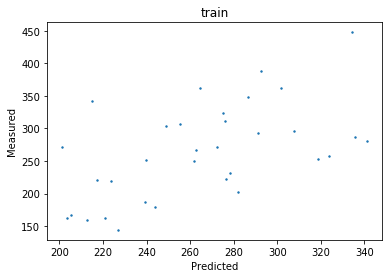

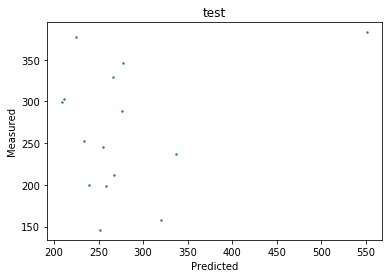

In [12]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(XX_train, YY_train)
# features="消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數".split("\t")

# print("參數")
# for i,j in zip(features,lm.coef_):
#     print(i,j)

    
    
predict=lm.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=lm.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [13]:
# predicted_sales = lm.predict(newDataXG)
# print("好店家預測")
# print(predicted_sales)

# predicted_sales = lm.predict(newDataXB)
# print("差店家預測")
# print(predicted_sales)

# 試跑SVR

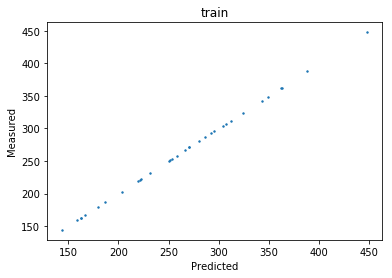

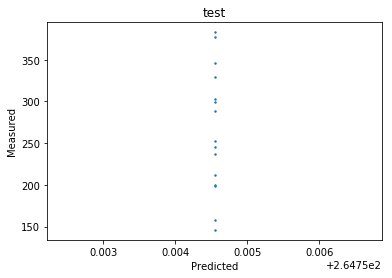

In [14]:

from sklearn import datasets
from sklearn.svm import SVR
import matplotlib.pyplot as plt
clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
clf.fit(XX_train, YY_train)
# predicted_sales = clf.predict(newDataXG)
# print("好店家預測")
# print(predicted_sales)

# predicted_sales = clf.predict(newDataXB)
# print("差店家預測")
# print(predicted_sales)

predict=clf.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=clf.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [15]:
# predict=clf.predict(newDataXB)
# plotPaint(predict,YB,R=1)

In [16]:
# predict=clf.predict(newDataXG)
# plotPaint(predict,YG,R=1)

In [17]:
# TryData="""63	333451	13	148	10	8	2	2
# 62	205551	12	127	2	5	3	1
# 58	174562	26	128	4	6	3	1
# 72	137555	12	100	4	9	1	1
# 79	223146	12	128	11	12	2	2
# 63	282141	22	187	16	15	2	1
# 52	157180	4	83	5	4	2	1
# 71	128373	8	52	1	3	3	0"""

# #"消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數"
# newDataXTry=np.array([[int(j) for j in i.split("\t")] for i in TryData.split('\n')])


# newDataxxTry=[]
# for i in range(len(newDataXTry.T)):
#     newDataxxTry.append(zscore(newDataXTry.T[i]))
# newDataxxTry=np.array(newDataxxTry).T


# clf.predict(newDataXTry)


# 引入keras模型

In [18]:
# from keras.datasets import mnist
from keras.models import Sequential # 序慣模型(可一層一層加入)
from keras.layers.core import Dense,Activation # 緊密層、啟動函數
from keras.layers import Dropout #減少overfitting的方法
from keras.utils import np_utils #one-hot 僅分類時使用

D:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 淺層神經網路(NN)

In [19]:
input_size=len(XX_train[0])#feature數量
batch_size=50#每批樣本大小
epochs=500#處理幾輪

model=Sequential()  #定義model
model.add(Dense(40,input_dim=input_size)) #加入層(緊密層) 產出個數40 輸入個數8 次元
model.add(Activation('relu')) #啟動函數
# model.add(Dense(3))  
# model.add(Activation('linear')) #啟動函數
model.add(Dense(1))  
model.add(Activation('linear')) #啟動函數

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
train_history=model.fit(XX_train,YY_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,verbose=1)
#劃出準確度歷程
import matplotlib.pyplot as plt
def show_tarin_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc="upper left")
    plt.show()
# show_tarin_history(train_history,'loss','loss')

Train on 26 samples, validate on 7 samples
Epoch 1/500
26/26 [==============================] - 1s 32ms/step - loss: 838300928.0000 - mean_absolute_error: 26090.6543 - val_loss: 1197705600.0000 - val_mean_absolute_error: 32189.1055
Epoch 2/500
26/26 [==============================] - 0s 192us/step - loss: 754772544.0000 - mean_absolute_error: 24754.6543 - val_loss: 1072757440.0000 - val_mean_absolute_error: 30461.4590
Epoch 3/500
26/26 [==============================] - 0s 154us/step - loss: 675779904.0000 - mean_absolute_error: 23421.3125 - val_loss: 955065920.0000 - val_mean_absolute_error: 28739.4707
Epoch 4/500
26/26 [==============================] - 0s 192us/step - loss: 601389824.0000 - mean_absolute_error: 22092.3301 - val_loss: 844713472.0000 - val_mean_absolute_error: 27025.5352
Epoch 5/500
26/26 [==============================] - 0s 154us/step - loss: 531653856.0000 - mean_absolute_error: 20769.5703 - val_loss: 741754496.0000 - val_mean_absolute_error: 25322.2188
Epoch 6/500

Epoch 45/500
26/26 [==============================] - 0s 115us/step - loss: 5881902.0000 - mean_absolute_error: 2226.3003 - val_loss: 6789436.5000 - val_mean_absolute_error: 2467.7507
Epoch 46/500
26/26 [==============================] - 0s 38us/step - loss: 4693627.0000 - mean_absolute_error: 1992.4497 - val_loss: 5177437.5000 - val_mean_absolute_error: 2159.7200
Epoch 47/500
26/26 [==============================] - 0s 77us/step - loss: 3623297.2500 - mean_absolute_error: 1754.7233 - val_loss: 3780775.7500 - val_mean_absolute_error: 1850.8639
Epoch 48/500
26/26 [==============================] - 0s 77us/step - loss: 2689416.0000 - mean_absolute_error: 1516.3585 - val_loss: 2614634.2500 - val_mean_absolute_error: 1545.0739
Epoch 49/500
26/26 [==============================] - 0s 77us/step - loss: 1902234.5000 - mean_absolute_error: 1280.3568 - val_loss: 1674707.2500 - val_mean_absolute_error: 1243.1318
Epoch 50/500
26/26 [==============================] - 0s 115us/step - loss: 1259158.

Epoch 91/500
26/26 [==============================] - 0s 77us/step - loss: 72039.5000 - mean_absolute_error: 258.8074 - val_loss: 52155.5898 - val_mean_absolute_error: 218.9553
Epoch 92/500
26/26 [==============================] - 0s 77us/step - loss: 71016.8672 - mean_absolute_error: 256.8964 - val_loss: 49229.4805 - val_mean_absolute_error: 211.5496
Epoch 93/500
26/26 [==============================] - 0s 77us/step - loss: 68013.5000 - mean_absolute_error: 251.1835 - val_loss: 44872.9570 - val_mean_absolute_error: 199.8727
Epoch 94/500
26/26 [==============================] - 0s 77us/step - loss: 63437.9219 - mean_absolute_error: 242.1702 - val_loss: 39609.6953 - val_mean_absolute_error: 184.4771
Epoch 95/500
26/26 [==============================] - 0s 77us/step - loss: 57710.6250 - mean_absolute_error: 230.2882 - val_loss: 34006.0625 - val_mean_absolute_error: 165.9723
Epoch 96/500
26/26 [==============================] - 0s 77us/step - loss: 51285.3828 - mean_absolute_error: 216.00

Epoch 138/500
26/26 [==============================] - 0s 77us/step - loss: 13726.9990 - mean_absolute_error: 90.4845 - val_loss: 24281.5215 - val_mean_absolute_error: 132.7088
Epoch 139/500
26/26 [==============================] - 0s 115us/step - loss: 13694.7344 - mean_absolute_error: 90.2219 - val_loss: 24532.5176 - val_mean_absolute_error: 133.2699
Epoch 140/500
26/26 [==============================] - 0s 77us/step - loss: 13645.4902 - mean_absolute_error: 89.8049 - val_loss: 24870.6914 - val_mean_absolute_error: 134.0107
Epoch 141/500
26/26 [==============================] - 0s 77us/step - loss: 13584.9795 - mean_absolute_error: 89.2595 - val_loss: 25281.9160 - val_mean_absolute_error: 134.8921
Epoch 142/500
26/26 [==============================] - 0s 77us/step - loss: 13518.3438 - mean_absolute_error: 88.6092 - val_loss: 25756.6836 - val_mean_absolute_error: 135.8826
Epoch 143/500
26/26 [==============================] - 0s 115us/step - loss: 13452.1943 - mean_absolute_error: 88.

Epoch 185/500
26/26 [==============================] - 0s 77us/step - loss: 13211.2256 - mean_absolute_error: 88.3971 - val_loss: 29410.1660 - val_mean_absolute_error: 144.7989
Epoch 186/500
26/26 [==============================] - 0s 77us/step - loss: 13210.3184 - mean_absolute_error: 88.4412 - val_loss: 29491.3887 - val_mean_absolute_error: 145.0299
Epoch 187/500
26/26 [==============================] - 0s 38us/step - loss: 13209.4414 - mean_absolute_error: 88.4862 - val_loss: 29574.8027 - val_mean_absolute_error: 145.2638
Epoch 188/500
26/26 [==============================] - 0s 77us/step - loss: 13208.4756 - mean_absolute_error: 88.5291 - val_loss: 29654.4102 - val_mean_absolute_error: 145.4889
Epoch 189/500
26/26 [==============================] - 0s 77us/step - loss: 13208.3545 - mean_absolute_error: 88.5726 - val_loss: 29728.3926 - val_mean_absolute_error: 145.6951
Epoch 190/500
26/26 [==============================] - 0s 77us/step - loss: 13208.0820 - mean_absolute_error: 88.61

Epoch 232/500
26/26 [==============================] - 0s 77us/step - loss: 13200.3174 - mean_absolute_error: 88.6238 - val_loss: 29792.1934 - val_mean_absolute_error: 145.8819
Epoch 233/500
26/26 [==============================] - 0s 77us/step - loss: 13200.2295 - mean_absolute_error: 88.6245 - val_loss: 29792.9414 - val_mean_absolute_error: 145.8856
Epoch 234/500
26/26 [==============================] - 0s 77us/step - loss: 13199.8896 - mean_absolute_error: 88.6245 - val_loss: 29793.8535 - val_mean_absolute_error: 145.8887
Epoch 235/500
26/26 [==============================] - 0s 115us/step - loss: 13199.7910 - mean_absolute_error: 88.6253 - val_loss: 29793.9199 - val_mean_absolute_error: 145.8881
Epoch 236/500
26/26 [==============================] - 0s 77us/step - loss: 13199.6133 - mean_absolute_error: 88.6252 - val_loss: 29793.6504 - val_mean_absolute_error: 145.8881
Epoch 237/500
26/26 [==============================] - 0s 77us/step - loss: 13199.2354 - mean_absolute_error: 88.6

Epoch 279/500
26/26 [==============================] - 0s 77us/step - loss: 13191.3369 - mean_absolute_error: 88.5775 - val_loss: 29746.4590 - val_mean_absolute_error: 145.7683
Epoch 280/500
26/26 [==============================] - 0s 77us/step - loss: 13191.0273 - mean_absolute_error: 88.5769 - val_loss: 29745.8965 - val_mean_absolute_error: 145.7680
Epoch 281/500
26/26 [==============================] - 0s 77us/step - loss: 13190.7188 - mean_absolute_error: 88.5760 - val_loss: 29745.6660 - val_mean_absolute_error: 145.7686
Epoch 282/500
26/26 [==============================] - 0s 77us/step - loss: 13190.3320 - mean_absolute_error: 88.5750 - val_loss: 29745.9707 - val_mean_absolute_error: 145.7686
Epoch 283/500
26/26 [==============================] - 0s 77us/step - loss: 13190.1260 - mean_absolute_error: 88.5735 - val_loss: 29745.6699 - val_mean_absolute_error: 145.7683
Epoch 284/500
26/26 [==============================] - 0s 77us/step - loss: 13189.8213 - mean_absolute_error: 88.57

Epoch 326/500
26/26 [==============================] - 0s 115us/step - loss: 13181.1973 - mean_absolute_error: 88.5382 - val_loss: 29725.3438 - val_mean_absolute_error: 145.7253
Epoch 327/500
26/26 [==============================] - 0s 77us/step - loss: 13180.6572 - mean_absolute_error: 88.5366 - val_loss: 29725.0352 - val_mean_absolute_error: 145.7247
Epoch 328/500
26/26 [==============================] - 0s 77us/step - loss: 13180.4082 - mean_absolute_error: 88.5357 - val_loss: 29726.0352 - val_mean_absolute_error: 145.7278
Epoch 329/500
26/26 [==============================] - 0s 77us/step - loss: 13180.4004 - mean_absolute_error: 88.5357 - val_loss: 29725.1875 - val_mean_absolute_error: 145.7258
Epoch 330/500
26/26 [==============================] - 0s 115us/step - loss: 13180.2793 - mean_absolute_error: 88.5354 - val_loss: 29724.9863 - val_mean_absolute_error: 145.7261
Epoch 331/500
26/26 [==============================] - 0s 77us/step - loss: 13180.0107 - mean_absolute_error: 88.

Epoch 373/500
26/26 [==============================] - 0s 77us/step - loss: 13170.1182 - mean_absolute_error: 88.4984 - val_loss: 29707.0898 - val_mean_absolute_error: 145.6884
Epoch 374/500
26/26 [==============================] - 0s 77us/step - loss: 13169.5254 - mean_absolute_error: 88.4964 - val_loss: 29706.3105 - val_mean_absolute_error: 145.6873
Epoch 375/500
26/26 [==============================] - 0s 115us/step - loss: 13169.1699 - mean_absolute_error: 88.4947 - val_loss: 29706.0918 - val_mean_absolute_error: 145.6864
Epoch 376/500
26/26 [==============================] - 0s 77us/step - loss: 13169.1982 - mean_absolute_error: 88.4953 - val_loss: 29705.7812 - val_mean_absolute_error: 145.6850
Epoch 377/500
26/26 [==============================] - 0s 77us/step - loss: 13169.1055 - mean_absolute_error: 88.4953 - val_loss: 29704.6035 - val_mean_absolute_error: 145.6820
Epoch 378/500
26/26 [==============================] - 0s 77us/step - loss: 13168.8018 - mean_absolute_error: 88.4

Epoch 420/500
26/26 [==============================] - 0s 115us/step - loss: 13158.0850 - mean_absolute_error: 88.4544 - val_loss: 29686.1387 - val_mean_absolute_error: 145.6470
Epoch 421/500
26/26 [==============================] - 0s 77us/step - loss: 13158.0146 - mean_absolute_error: 88.4540 - val_loss: 29686.2676 - val_mean_absolute_error: 145.6456
Epoch 422/500
26/26 [==============================] - 0s 115us/step - loss: 13157.7393 - mean_absolute_error: 88.4529 - val_loss: 29685.2656 - val_mean_absolute_error: 145.6434
Epoch 423/500
26/26 [==============================] - 0s 77us/step - loss: 13157.2607 - mean_absolute_error: 88.4514 - val_loss: 29685.8398 - val_mean_absolute_error: 145.6445
Epoch 424/500
26/26 [==============================] - 0s 77us/step - loss: 13156.7764 - mean_absolute_error: 88.4493 - val_loss: 29685.5059 - val_mean_absolute_error: 145.6437
Epoch 425/500
26/26 [==============================] - 0s 115us/step - loss: 13156.6318 - mean_absolute_error: 88

Epoch 467/500
26/26 [==============================] - 0s 115us/step - loss: 13145.4082 - mean_absolute_error: 88.4076 - val_loss: 29665.1250 - val_mean_absolute_error: 145.6027
Epoch 468/500
26/26 [==============================] - 0s 115us/step - loss: 13145.3340 - mean_absolute_error: 88.4073 - val_loss: 29665.2949 - val_mean_absolute_error: 145.6055
Epoch 469/500
26/26 [==============================] - 0s 115us/step - loss: 13144.9707 - mean_absolute_error: 88.4063 - val_loss: 29665.0625 - val_mean_absolute_error: 145.6046
Epoch 470/500
26/26 [==============================] - 0s 77us/step - loss: 13144.7129 - mean_absolute_error: 88.4061 - val_loss: 29664.1738 - val_mean_absolute_error: 145.6027
Epoch 471/500
26/26 [==============================] - 0s 77us/step - loss: 13144.5449 - mean_absolute_error: 88.4050 - val_loss: 29664.7324 - val_mean_absolute_error: 145.6027
Epoch 472/500
26/26 [==============================] - 0s 77us/step - loss: 13144.1631 - mean_absolute_error: 88

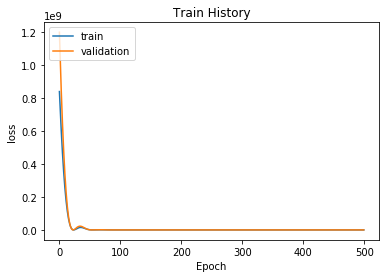

In [20]:
show_tarin_history(train_history,'loss','val_loss')

In [21]:
error=model.predict(XX_train).reshape([len(XX_train)])-np.array(YY_train)
np.average(error**2)**(1/2)

128.99027182041186

In [22]:
error=model.predict(XX_test).reshape([len(XX_test)])-np.array(YY_test)
np.average(error**2)**(1/2)

147.8224645452015

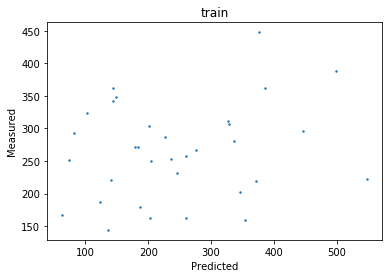

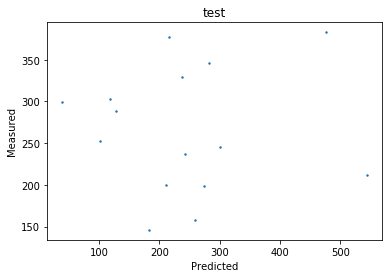

In [23]:
predict=model.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=model.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [24]:
# predicted_sales = model.predict(newDataxxG)
# print("好店家預測")
# print(predicted_sales)
# predicted_sales = model.predict(newDataxxB)
# print("差店家預測")
# print(predicted_sales)
# predict=model.predict(newDataxxG)
# plotPaint(predict,YG,R=1)
# predict=model.predict(newDataxxB)
# plotPaint(predict,YB,R=1)

# 多層(DNN)

In [25]:
input_size=len(XX_train[0])#feature數量
batch_size=50#每批樣本大小
# epochs=5000#處理幾輪
epochs=1500#處理幾輪

model=Sequential()  #定義model
model.add(Dense(40,input_dim=input_size)) #加入層(緊密層) 產出個數40 輸入個數8 次元
model.add(Activation('relu')) #啟動函數
model.add(Dense(200)) 
model.add(Activation('relu')) 
model.add(Dense(200)) 
model.add(Dropout(0.3)) 
model.add(Activation('relu')) 
model.add(Dense(250)) 
model.add(Activation('relu')) 
for i in range(20):
    model.add(Dense(200-i*8)) 
    model.add(Activation('relu')) 
model.add(Dense(20)) 
# model.add(Dense(50)) 
model.add(Activation('relu'))
model.add(Dropout(0.2)) 

model.add(Dense(1))  
model.add(Activation('linear')) #啟動函數

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 40)                520       
_________________________________________________________________
activation_3 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               8200      
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
__________

In [27]:
#loss成本函數mse(均方差)  optimizer最佳化工具adam(會自動調整學習速率、並繼承上一步的方法) metrics性能評估方法()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# model.compile(loss="MSE",metrics=['accuracy'],optimizer='sgd')

In [28]:
#訓練開始 xx為feature Y為label  batch_size為每次放多少進去 epochs為處理幾輪 validation_split為抽多少樣本來驗證 verbose=1為每次顯示
train_history=model.fit(XX_train,YY_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,verbose=1)
# train_history=model.fit(xx,Y,batch_size=batch_size,epochs=epochs,verbose=1)

Train on 26 samples, validate on 7 samples
Epoch 1/1500
26/26 [==============================] - 2s 89ms/step - loss: 81353.4141 - mean_absolute_error: 274.9166 - val_loss: 61862.1133 - val_mean_absolute_error: 242.4586
Epoch 2/1500
26/26 [==============================] - 0s 462us/step - loss: 79816.6562 - mean_absolute_error: 272.0256 - val_loss: 57440.9727 - val_mean_absolute_error: 232.6544
Epoch 3/1500
26/26 [==============================] - 0s 423us/step - loss: 74775.5859 - mean_absolute_error: 263.4454 - val_loss: 46300.4180 - val_mean_absolute_error: 205.3608
Epoch 4/1500
26/26 [==============================] - 0s 423us/step - loss: 61824.1445 - mean_absolute_error: 237.6918 - val_loss: 17559.8848 - val_mean_absolute_error: 100.3995
Epoch 5/1500
26/26 [==============================] - 0s 423us/step - loss: 24410.8320 - mean_absolute_error: 132.5812 - val_loss: 158875.9531 - val_mean_absolute_error: 329.8519
Epoch 6/1500
26/26 [==============================] - 0s 539us/step

Epoch 47/1500
26/26 [==============================] - 0s 423us/step - loss: 20069.6113 - mean_absolute_error: 121.8709 - val_loss: 15670.3525 - val_mean_absolute_error: 90.2561
Epoch 48/1500
26/26 [==============================] - 0s 500us/step - loss: 20120.8340 - mean_absolute_error: 118.1116 - val_loss: 16046.2236 - val_mean_absolute_error: 90.2413
Epoch 49/1500
26/26 [==============================] - 0s 500us/step - loss: 21356.7930 - mean_absolute_error: 122.9373 - val_loss: 15548.1592 - val_mean_absolute_error: 92.5180
Epoch 50/1500
26/26 [==============================] - 0s 385us/step - loss: 17877.4414 - mean_absolute_error: 104.7085 - val_loss: 17063.7285 - val_mean_absolute_error: 110.3115
Epoch 51/1500
26/26 [==============================] - 0s 385us/step - loss: 15868.0420 - mean_absolute_error: 103.1054 - val_loss: 26385.2910 - val_mean_absolute_error: 137.4179
Epoch 52/1500
26/26 [==============================] - 0s 423us/step - loss: 15486.4258 - mean_absolute_erro

Epoch 93/1500
26/26 [==============================] - 0s 462us/step - loss: 15170.6709 - mean_absolute_error: 94.6414 - val_loss: 27706.6055 - val_mean_absolute_error: 141.3358
Epoch 94/1500
26/26 [==============================] - 0s 423us/step - loss: 16676.0703 - mean_absolute_error: 106.8276 - val_loss: 26197.4102 - val_mean_absolute_error: 136.8644
Epoch 95/1500
26/26 [==============================] - 0s 423us/step - loss: 17706.5176 - mean_absolute_error: 106.3138 - val_loss: 18708.3945 - val_mean_absolute_error: 116.9931
Epoch 96/1500
26/26 [==============================] - 0s 500us/step - loss: 16257.4434 - mean_absolute_error: 105.7219 - val_loss: 15490.2725 - val_mean_absolute_error: 94.8267
Epoch 97/1500
26/26 [==============================] - 0s 500us/step - loss: 21483.2383 - mean_absolute_error: 122.5664 - val_loss: 15853.9854 - val_mean_absolute_error: 89.1626
Epoch 98/1500
26/26 [==============================] - 0s 500us/step - loss: 17914.1328 - mean_absolute_erro

Epoch 139/1500
26/26 [==============================] - 0s 462us/step - loss: 16185.1260 - mean_absolute_error: 103.3486 - val_loss: 19817.3867 - val_mean_absolute_error: 120.5221
Epoch 140/1500
26/26 [==============================] - 0s 462us/step - loss: 13509.0566 - mean_absolute_error: 95.8073 - val_loss: 17803.3730 - val_mean_absolute_error: 113.6617
Epoch 141/1500
26/26 [==============================] - 0s 423us/step - loss: 15486.6787 - mean_absolute_error: 103.5775 - val_loss: 16859.6602 - val_mean_absolute_error: 109.3725
Epoch 142/1500
26/26 [==============================] - 0s 423us/step - loss: 15457.4727 - mean_absolute_error: 100.7653 - val_loss: 16073.5732 - val_mean_absolute_error: 104.4311
Epoch 143/1500
26/26 [==============================] - 0s 423us/step - loss: 15416.7100 - mean_absolute_error: 102.1753 - val_loss: 16234.0449 - val_mean_absolute_error: 105.6284
Epoch 144/1500
26/26 [==============================] - 0s 423us/step - loss: 17931.4238 - mean_absol

Epoch 185/1500
26/26 [==============================] - 0s 462us/step - loss: 15547.8174 - mean_absolute_error: 105.1180 - val_loss: 18989.7227 - val_mean_absolute_error: 117.9641
Epoch 186/1500
26/26 [==============================] - 0s 462us/step - loss: 12252.0352 - mean_absolute_error: 85.0227 - val_loss: 20759.2246 - val_mean_absolute_error: 123.1670
Epoch 187/1500
26/26 [==============================] - 0s 462us/step - loss: 18534.5156 - mean_absolute_error: 114.4714 - val_loss: 19690.6250 - val_mean_absolute_error: 120.1535
Epoch 188/1500
26/26 [==============================] - 0s 423us/step - loss: 17368.3477 - mean_absolute_error: 100.5130 - val_loss: 16519.1465 - val_mean_absolute_error: 107.5389
Epoch 189/1500
26/26 [==============================] - 0s 423us/step - loss: 14033.3887 - mean_absolute_error: 95.7433 - val_loss: 15976.6045 - val_mean_absolute_error: 103.7494
Epoch 190/1500
26/26 [==============================] - 0s 423us/step - loss: 14831.1094 - mean_absolu

Epoch 231/1500
26/26 [==============================] - 0s 423us/step - loss: 13912.4268 - mean_absolute_error: 97.1115 - val_loss: 19089.7090 - val_mean_absolute_error: 118.3039
Epoch 232/1500
26/26 [==============================] - 0s 423us/step - loss: 14804.8770 - mean_absolute_error: 104.0112 - val_loss: 20158.7598 - val_mean_absolute_error: 121.5206
Epoch 233/1500
26/26 [==============================] - 0s 462us/step - loss: 16683.7031 - mean_absolute_error: 100.6389 - val_loss: 17811.8184 - val_mean_absolute_error: 113.7588
Epoch 234/1500
26/26 [==============================] - 0s 462us/step - loss: 18430.9375 - mean_absolute_error: 113.6595 - val_loss: 16591.5742 - val_mean_absolute_error: 108.0412
Epoch 235/1500
26/26 [==============================] - 0s 462us/step - loss: 13734.6338 - mean_absolute_error: 93.0592 - val_loss: 16776.4531 - val_mean_absolute_error: 109.0571
Epoch 236/1500
26/26 [==============================] - 0s 423us/step - loss: 14931.7744 - mean_absolu

Epoch 277/1500
26/26 [==============================] - 0s 462us/step - loss: 19912.9180 - mean_absolute_error: 112.6597 - val_loss: 19944.9336 - val_mean_absolute_error: 120.9170
Epoch 278/1500
26/26 [==============================] - 0s 423us/step - loss: 14145.9932 - mean_absolute_error: 96.2361 - val_loss: 27447.2383 - val_mean_absolute_error: 140.6861
Epoch 279/1500
26/26 [==============================] - 0s 462us/step - loss: 17379.0098 - mean_absolute_error: 99.8872 - val_loss: 23587.0000 - val_mean_absolute_error: 129.8865
Epoch 280/1500
26/26 [==============================] - 0s 423us/step - loss: 17818.1250 - mean_absolute_error: 109.8665 - val_loss: 17857.2910 - val_mean_absolute_error: 113.9820
Epoch 281/1500
26/26 [==============================] - 0s 423us/step - loss: 11909.0264 - mean_absolute_error: 85.4093 - val_loss: 16199.4141 - val_mean_absolute_error: 105.7190
Epoch 282/1500
26/26 [==============================] - 0s 423us/step - loss: 19691.7793 - mean_absolut

Epoch 323/1500
26/26 [==============================] - 0s 500us/step - loss: 19952.5234 - mean_absolute_error: 121.0314 - val_loss: 17323.5723 - val_mean_absolute_error: 111.8099
Epoch 324/1500
26/26 [==============================] - 0s 462us/step - loss: 14583.1670 - mean_absolute_error: 98.4472 - val_loss: 19618.5508 - val_mean_absolute_error: 119.9684
Epoch 325/1500
26/26 [==============================] - 0s 462us/step - loss: 15458.0830 - mean_absolute_error: 101.7977 - val_loss: 24215.7715 - val_mean_absolute_error: 131.1965
Epoch 326/1500
26/26 [==============================] - 0s 462us/step - loss: 13919.8135 - mean_absolute_error: 99.6283 - val_loss: 24393.5996 - val_mean_absolute_error: 131.5618
Epoch 327/1500
26/26 [==============================] - 0s 423us/step - loss: 21367.2461 - mean_absolute_error: 115.0308 - val_loss: 17555.5332 - val_mean_absolute_error: 112.8056
Epoch 328/1500
26/26 [==============================] - 0s 423us/step - loss: 13862.9707 - mean_absolu

Epoch 369/1500
26/26 [==============================] - 0s 423us/step - loss: 17181.8516 - mean_absolute_error: 103.2875 - val_loss: 17476.6914 - val_mean_absolute_error: 112.5151
Epoch 370/1500
26/26 [==============================] - 0s 462us/step - loss: 13439.8281 - mean_absolute_error: 94.5998 - val_loss: 16409.2500 - val_mean_absolute_error: 107.2572
Epoch 371/1500
26/26 [==============================] - 0s 462us/step - loss: 15408.9883 - mean_absolute_error: 101.9797 - val_loss: 15891.7451 - val_mean_absolute_error: 103.6813
Epoch 372/1500
26/26 [==============================] - 0s 423us/step - loss: 12918.9062 - mean_absolute_error: 82.1785 - val_loss: 15708.5156 - val_mean_absolute_error: 102.0185
Epoch 373/1500
26/26 [==============================] - 0s 423us/step - loss: 14624.6885 - mean_absolute_error: 98.0872 - val_loss: 16825.6113 - val_mean_absolute_error: 109.5312
Epoch 374/1500
26/26 [==============================] - 0s 423us/step - loss: 14703.2324 - mean_absolut

Epoch 415/1500
26/26 [==============================] - 0s 423us/step - loss: 11468.9180 - mean_absolute_error: 85.7660 - val_loss: 18893.4785 - val_mean_absolute_error: 117.7384
Epoch 416/1500
26/26 [==============================] - 0s 500us/step - loss: 14747.9424 - mean_absolute_error: 95.8808 - val_loss: 19111.0645 - val_mean_absolute_error: 118.4355
Epoch 417/1500
26/26 [==============================] - 0s 462us/step - loss: 14633.5527 - mean_absolute_error: 100.7542 - val_loss: 18485.6367 - val_mean_absolute_error: 116.3737
Epoch 418/1500
26/26 [==============================] - 0s 423us/step - loss: 15903.5156 - mean_absolute_error: 88.1281 - val_loss: 16925.9102 - val_mean_absolute_error: 110.0893
Epoch 419/1500
26/26 [==============================] - 0s 423us/step - loss: 14732.0195 - mean_absolute_error: 94.0012 - val_loss: 17431.4199 - val_mean_absolute_error: 112.3704
Epoch 420/1500
26/26 [==============================] - 0s 423us/step - loss: 16885.3066 - mean_absolute

Epoch 461/1500
26/26 [==============================] - 0s 462us/step - loss: 13464.1055 - mean_absolute_error: 92.0975 - val_loss: 17300.6914 - val_mean_absolute_error: 111.8691
Epoch 462/1500
26/26 [==============================] - 0s 423us/step - loss: 15149.5557 - mean_absolute_error: 98.0163 - val_loss: 18133.2793 - val_mean_absolute_error: 115.1591
Epoch 463/1500
26/26 [==============================] - 0s 500us/step - loss: 13194.4844 - mean_absolute_error: 92.5346 - val_loss: 19908.1914 - val_mean_absolute_error: 120.8397
Epoch 464/1500
26/26 [==============================] - 0s 462us/step - loss: 15404.2412 - mean_absolute_error: 95.1375 - val_loss: 20566.1660 - val_mean_absolute_error: 122.6571
Epoch 465/1500
26/26 [==============================] - 0s 423us/step - loss: 16785.6992 - mean_absolute_error: 110.8194 - val_loss: 17741.4961 - val_mean_absolute_error: 113.6847
Epoch 466/1500
26/26 [==============================] - 0s 462us/step - loss: 21016.0039 - mean_absolute

Epoch 507/1500
26/26 [==============================] - 0s 423us/step - loss: 13045.4854 - mean_absolute_error: 89.1983 - val_loss: 19503.8613 - val_mean_absolute_error: 119.6697
Epoch 508/1500
26/26 [==============================] - 0s 423us/step - loss: 13335.5801 - mean_absolute_error: 94.6810 - val_loss: 21027.1523 - val_mean_absolute_error: 123.8601
Epoch 509/1500
26/26 [==============================] - 0s 423us/step - loss: 11480.7402 - mean_absolute_error: 87.6408 - val_loss: 21628.1660 - val_mean_absolute_error: 125.3581
Epoch 510/1500
26/26 [==============================] - 0s 462us/step - loss: 16004.9023 - mean_absolute_error: 100.7820 - val_loss: 18886.9082 - val_mean_absolute_error: 117.7619
Epoch 511/1500
26/26 [==============================] - 0s 423us/step - loss: 18155.0254 - mean_absolute_error: 106.4504 - val_loss: 15716.0166 - val_mean_absolute_error: 102.7759
Epoch 512/1500
26/26 [==============================] - 0s 423us/step - loss: 15349.9072 - mean_absolut

Epoch 553/1500
26/26 [==============================] - 0s 462us/step - loss: 18480.6016 - mean_absolute_error: 107.7276 - val_loss: 18231.6426 - val_mean_absolute_error: 115.5768
Epoch 554/1500
26/26 [==============================] - 0s 462us/step - loss: 15573.6582 - mean_absolute_error: 102.3409 - val_loss: 16721.9414 - val_mean_absolute_error: 109.3279
Epoch 555/1500
26/26 [==============================] - 0s 423us/step - loss: 11806.7236 - mean_absolute_error: 86.7063 - val_loss: 16778.7500 - val_mean_absolute_error: 109.6114
Epoch 556/1500
26/26 [==============================] - 0s 423us/step - loss: 17629.0430 - mean_absolute_error: 111.3161 - val_loss: 17950.6680 - val_mean_absolute_error: 114.5620
Epoch 557/1500
26/26 [==============================] - 0s 423us/step - loss: 12549.9697 - mean_absolute_error: 91.8884 - val_loss: 20099.7715 - val_mean_absolute_error: 121.3912
Epoch 558/1500
26/26 [==============================] - 0s 423us/step - loss: 17302.0488 - mean_absolu

Epoch 599/1500
26/26 [==============================] - 0s 462us/step - loss: 13215.8535 - mean_absolute_error: 95.7126 - val_loss: 17056.7637 - val_mean_absolute_error: 110.9703
Epoch 600/1500
26/26 [==============================] - 0s 500us/step - loss: 11448.2197 - mean_absolute_error: 80.8398 - val_loss: 16086.9229 - val_mean_absolute_error: 105.8421
Epoch 601/1500
26/26 [==============================] - 0s 500us/step - loss: 14082.8770 - mean_absolute_error: 99.3559 - val_loss: 15909.7734 - val_mean_absolute_error: 104.6412
Epoch 602/1500
26/26 [==============================] - 0s 462us/step - loss: 14621.1055 - mean_absolute_error: 99.9475 - val_loss: 16632.5059 - val_mean_absolute_error: 108.9510
Epoch 603/1500
26/26 [==============================] - 0s 423us/step - loss: 16364.6553 - mean_absolute_error: 98.3995 - val_loss: 17631.1191 - val_mean_absolute_error: 113.3786
Epoch 604/1500
26/26 [==============================] - 0s 423us/step - loss: 14874.4229 - mean_absolute_

Epoch 645/1500
26/26 [==============================] - 0s 500us/step - loss: 12951.9365 - mean_absolute_error: 91.8694 - val_loss: 15805.1670 - val_mean_absolute_error: 104.0478
Epoch 646/1500
26/26 [==============================] - 0s 462us/step - loss: 14047.0820 - mean_absolute_error: 96.4539 - val_loss: 15662.7705 - val_mean_absolute_error: 102.9148
Epoch 647/1500
26/26 [==============================] - 0s 385us/step - loss: 15187.7480 - mean_absolute_error: 94.6018 - val_loss: 16395.4785 - val_mean_absolute_error: 107.7998
Epoch 648/1500
26/26 [==============================] - 0s 462us/step - loss: 13783.2168 - mean_absolute_error: 90.0188 - val_loss: 17987.7637 - val_mean_absolute_error: 114.7682
Epoch 649/1500
26/26 [==============================] - 0s 462us/step - loss: 12876.9277 - mean_absolute_error: 90.6316 - val_loss: 21206.3789 - val_mean_absolute_error: 124.2982
Epoch 650/1500
26/26 [==============================] - 0s 500us/step - loss: 18505.2676 - mean_absolute_

Epoch 691/1500
26/26 [==============================] - 0s 462us/step - loss: 17433.2676 - mean_absolute_error: 108.6256 - val_loss: 16434.6914 - val_mean_absolute_error: 108.1166
Epoch 692/1500
26/26 [==============================] - 0s 423us/step - loss: 14079.9102 - mean_absolute_error: 93.7448 - val_loss: 19232.0586 - val_mean_absolute_error: 118.9026
Epoch 693/1500
26/26 [==============================] - 0s 462us/step - loss: 16087.5430 - mean_absolute_error: 110.4896 - val_loss: 22579.9785 - val_mean_absolute_error: 127.5351
Epoch 694/1500
26/26 [==============================] - 0s 462us/step - loss: 11612.0537 - mean_absolute_error: 81.0503 - val_loss: 25432.3574 - val_mean_absolute_error: 134.9697
Epoch 695/1500
26/26 [==============================] - 0s 462us/step - loss: 16658.5020 - mean_absolute_error: 94.5564 - val_loss: 21547.6602 - val_mean_absolute_error: 125.1285
Epoch 696/1500
26/26 [==============================] - 0s 539us/step - loss: 13185.3848 - mean_absolut

Epoch 737/1500
26/26 [==============================] - 0s 462us/step - loss: 13633.9707 - mean_absolute_error: 93.1540 - val_loss: 16452.3691 - val_mean_absolute_error: 108.3145
Epoch 738/1500
26/26 [==============================] - 0s 539us/step - loss: 14005.6055 - mean_absolute_error: 92.6882 - val_loss: 19135.9238 - val_mean_absolute_error: 118.6265
Epoch 739/1500
26/26 [==============================] - 0s 500us/step - loss: 13761.1553 - mean_absolute_error: 94.4903 - val_loss: 21575.1660 - val_mean_absolute_error: 125.1840
Epoch 740/1500
26/26 [==============================] - 0s 500us/step - loss: 12800.4668 - mean_absolute_error: 90.1475 - val_loss: 22057.8555 - val_mean_absolute_error: 126.3249
Epoch 741/1500
26/26 [==============================] - 0s 462us/step - loss: 17121.9824 - mean_absolute_error: 104.2033 - val_loss: 17464.5840 - val_mean_absolute_error: 112.8768
Epoch 742/1500
26/26 [==============================] - 0s 462us/step - loss: 16640.4004 - mean_absolute

Epoch 783/1500
26/26 [==============================] - 0s 423us/step - loss: 17122.0391 - mean_absolute_error: 105.7622 - val_loss: 22734.5312 - val_mean_absolute_error: 127.8375
Epoch 784/1500
26/26 [==============================] - 0s 423us/step - loss: 18015.3047 - mean_absolute_error: 105.8293 - val_loss: 17057.7227 - val_mean_absolute_error: 111.2729
Epoch 785/1500
26/26 [==============================] - 0s 462us/step - loss: 14227.0879 - mean_absolute_error: 99.8869 - val_loss: 15614.5264 - val_mean_absolute_error: 103.2580
Epoch 786/1500
26/26 [==============================] - 0s 423us/step - loss: 15958.5723 - mean_absolute_error: 111.1429 - val_loss: 16223.1162 - val_mean_absolute_error: 107.2332
Epoch 787/1500
26/26 [==============================] - 0s 423us/step - loss: 16167.7119 - mean_absolute_error: 103.8274 - val_loss: 17683.9004 - val_mean_absolute_error: 113.7851
Epoch 788/1500
26/26 [==============================] - 0s 462us/step - loss: 16212.5010 - mean_absol

Epoch 829/1500
26/26 [==============================] - 0s 423us/step - loss: 14569.4443 - mean_absolute_error: 101.0056 - val_loss: 17315.5840 - val_mean_absolute_error: 112.4180
Epoch 830/1500
26/26 [==============================] - 0s 423us/step - loss: 15502.7617 - mean_absolute_error: 103.3727 - val_loss: 19336.7773 - val_mean_absolute_error: 119.2605
Epoch 831/1500
26/26 [==============================] - 0s 462us/step - loss: 17107.6895 - mean_absolute_error: 104.1387 - val_loss: 16886.8984 - val_mean_absolute_error: 110.6226
Epoch 832/1500
26/26 [==============================] - 0s 462us/step - loss: 14636.1367 - mean_absolute_error: 97.9996 - val_loss: 16319.2900 - val_mean_absolute_error: 107.9017
Epoch 833/1500
26/26 [==============================] - 0s 462us/step - loss: 13664.7197 - mean_absolute_error: 90.5017 - val_loss: 16139.2588 - val_mean_absolute_error: 106.9269
Epoch 834/1500
26/26 [==============================] - 0s 462us/step - loss: 11673.1865 - mean_absolu

Epoch 875/1500
26/26 [==============================] - 0s 462us/step - loss: 14308.0898 - mean_absolute_error: 94.5076 - val_loss: 22158.9492 - val_mean_absolute_error: 126.5024
Epoch 876/1500
26/26 [==============================] - 0s 423us/step - loss: 17102.1270 - mean_absolute_error: 99.1434 - val_loss: 18420.8379 - val_mean_absolute_error: 116.4404
Epoch 877/1500
26/26 [==============================] - 0s 423us/step - loss: 15550.8711 - mean_absolute_error: 101.1719 - val_loss: 15357.3047 - val_mean_absolute_error: 101.6240
Epoch 878/1500
26/26 [==============================] - 0s 462us/step - loss: 16581.2520 - mean_absolute_error: 108.0219 - val_loss: 14942.3369 - val_mean_absolute_error: 95.5699
Epoch 879/1500
26/26 [==============================] - 0s 462us/step - loss: 15684.4336 - mean_absolute_error: 99.7842 - val_loss: 15027.9238 - val_mean_absolute_error: 97.6250
Epoch 880/1500
26/26 [==============================] - 0s 423us/step - loss: 14598.2646 - mean_absolute_

Epoch 921/1500
26/26 [==============================] - 0s 462us/step - loss: 13750.9990 - mean_absolute_error: 97.0322 - val_loss: 16949.4219 - val_mean_absolute_error: 111.0365
Epoch 922/1500
26/26 [==============================] - 0s 500us/step - loss: 15108.8438 - mean_absolute_error: 101.4810 - val_loss: 18997.3613 - val_mean_absolute_error: 118.2763
Epoch 923/1500
26/26 [==============================] - 0s 500us/step - loss: 12153.0293 - mean_absolute_error: 88.2764 - val_loss: 24718.4961 - val_mean_absolute_error: 133.0092
Epoch 924/1500
26/26 [==============================] - 0s 423us/step - loss: 14780.5791 - mean_absolute_error: 98.7117 - val_loss: 24476.3125 - val_mean_absolute_error: 132.2322
Epoch 925/1500
26/26 [==============================] - 0s 423us/step - loss: 18240.5918 - mean_absolute_error: 110.8154 - val_loss: 16187.0029 - val_mean_absolute_error: 107.4358
Epoch 926/1500
26/26 [==============================] - 0s 423us/step - loss: 17851.0781 - mean_absolut

Epoch 967/1500
26/26 [==============================] - 0s 423us/step - loss: 16070.7168 - mean_absolute_error: 99.9910 - val_loss: 26795.4004 - val_mean_absolute_error: 139.3834
Epoch 968/1500
26/26 [==============================] - 0s 423us/step - loss: 14954.9727 - mean_absolute_error: 99.5494 - val_loss: 30482.5684 - val_mean_absolute_error: 149.3344
Epoch 969/1500
26/26 [==============================] - 0s 462us/step - loss: 23653.8711 - mean_absolute_error: 121.6272 - val_loss: 17547.5410 - val_mean_absolute_error: 113.4994
Epoch 970/1500
26/26 [==============================] - 0s 462us/step - loss: 12934.2412 - mean_absolute_error: 88.1688 - val_loss: 14825.4600 - val_mean_absolute_error: 95.3560
Epoch 971/1500
26/26 [==============================] - 0s 423us/step - loss: 14202.8135 - mean_absolute_error: 95.5538 - val_loss: 14894.5684 - val_mean_absolute_error: 89.1642
Epoch 972/1500
26/26 [==============================] - 0s 462us/step - loss: 18960.5137 - mean_absolute_e

Epoch 1013/1500
26/26 [==============================] - 0s 462us/step - loss: 13064.3867 - mean_absolute_error: 86.4575 - val_loss: 18052.6758 - val_mean_absolute_error: 115.3302
Epoch 1014/1500
26/26 [==============================] - 0s 539us/step - loss: 14352.4668 - mean_absolute_error: 98.4446 - val_loss: 16821.5371 - val_mean_absolute_error: 110.7022
Epoch 1015/1500
26/26 [==============================] - 0s 462us/step - loss: 13778.1338 - mean_absolute_error: 92.5931 - val_loss: 16508.5781 - val_mean_absolute_error: 109.3210
Epoch 1016/1500
26/26 [==============================] - 0s 462us/step - loss: 15277.1729 - mean_absolute_error: 99.3845 - val_loss: 16099.6475 - val_mean_absolute_error: 107.3171
Epoch 1017/1500
26/26 [==============================] - 0s 423us/step - loss: 13388.2324 - mean_absolute_error: 91.2601 - val_loss: 16195.3281 - val_mean_absolute_error: 107.8146
Epoch 1018/1500
26/26 [==============================] - 0s 423us/step - loss: 16017.8105 - mean_abs

Epoch 1059/1500
26/26 [==============================] - 0s 423us/step - loss: 18567.6816 - mean_absolute_error: 103.2436 - val_loss: 15255.1826 - val_mean_absolute_error: 102.2100
Epoch 1060/1500
26/26 [==============================] - 0s 423us/step - loss: 14841.7197 - mean_absolute_error: 99.1998 - val_loss: 14740.3525 - val_mean_absolute_error: 89.4183
Epoch 1061/1500
26/26 [==============================] - 0s 423us/step - loss: 17353.0566 - mean_absolute_error: 115.8701 - val_loss: 14862.1025 - val_mean_absolute_error: 87.3092
Epoch 1062/1500
26/26 [==============================] - 0s 423us/step - loss: 16431.2363 - mean_absolute_error: 104.7540 - val_loss: 14675.3994 - val_mean_absolute_error: 94.2475
Epoch 1063/1500
26/26 [==============================] - 0s 462us/step - loss: 16761.6992 - mean_absolute_error: 103.1859 - val_loss: 17163.6543 - val_mean_absolute_error: 112.1953
Epoch 1064/1500
26/26 [==============================] - 0s 462us/step - loss: 14887.8760 - mean_ab

Epoch 1105/1500
26/26 [==============================] - 0s 423us/step - loss: 13134.2031 - mean_absolute_error: 87.1338 - val_loss: 19112.4785 - val_mean_absolute_error: 118.6887
Epoch 1106/1500
26/26 [==============================] - 0s 462us/step - loss: 15817.8301 - mean_absolute_error: 102.7565 - val_loss: 17201.6973 - val_mean_absolute_error: 112.4365
Epoch 1107/1500
26/26 [==============================] - 0s 462us/step - loss: 14952.6152 - mean_absolute_error: 91.3961 - val_loss: 15937.9463 - val_mean_absolute_error: 106.8779
Epoch 1108/1500
26/26 [==============================] - 0s 423us/step - loss: 11988.2090 - mean_absolute_error: 86.0202 - val_loss: 15565.7832 - val_mean_absolute_error: 104.7727
Epoch 1109/1500
26/26 [==============================] - 0s 462us/step - loss: 13871.6895 - mean_absolute_error: 95.3397 - val_loss: 15752.6855 - val_mean_absolute_error: 105.8781
Epoch 1110/1500
26/26 [==============================] - 0s 462us/step - loss: 16469.7734 - mean_ab

Epoch 1151/1500
26/26 [==============================] - 0s 462us/step - loss: 12054.3164 - mean_absolute_error: 90.0816 - val_loss: 16158.0537 - val_mean_absolute_error: 108.1693
Epoch 1152/1500
26/26 [==============================] - 0s 423us/step - loss: 14907.3506 - mean_absolute_error: 96.7170 - val_loss: 16934.3926 - val_mean_absolute_error: 111.5074
Epoch 1153/1500
26/26 [==============================] - 0s 462us/step - loss: 19609.7559 - mean_absolute_error: 114.8732 - val_loss: 16377.1094 - val_mean_absolute_error: 109.1841
Epoch 1154/1500
26/26 [==============================] - 0s 462us/step - loss: 14764.8594 - mean_absolute_error: 98.5186 - val_loss: 16016.4951 - val_mean_absolute_error: 107.4951
Epoch 1155/1500
26/26 [==============================] - 0s 423us/step - loss: 14489.4473 - mean_absolute_error: 98.0293 - val_loss: 15909.0889 - val_mean_absolute_error: 106.9586
Epoch 1156/1500
26/26 [==============================] - 0s 462us/step - loss: 13036.5820 - mean_ab

Epoch 1197/1500
26/26 [==============================] - 0s 462us/step - loss: 21211.8320 - mean_absolute_error: 112.5570 - val_loss: 19322.8281 - val_mean_absolute_error: 119.2985
Epoch 1198/1500
26/26 [==============================] - 0s 423us/step - loss: 16679.4082 - mean_absolute_error: 100.6539 - val_loss: 15666.5400 - val_mean_absolute_error: 105.9029
Epoch 1199/1500
26/26 [==============================] - 0s 462us/step - loss: 13237.4736 - mean_absolute_error: 92.1165 - val_loss: 14417.4150 - val_mean_absolute_error: 94.0313
Epoch 1200/1500
26/26 [==============================] - 0s 462us/step - loss: 16382.1104 - mean_absolute_error: 106.9408 - val_loss: 14390.9863 - val_mean_absolute_error: 92.4009
Epoch 1201/1500
26/26 [==============================] - 0s 423us/step - loss: 16795.4082 - mean_absolute_error: 106.5210 - val_loss: 14699.4541 - val_mean_absolute_error: 98.8702
Epoch 1202/1500
26/26 [==============================] - 0s 462us/step - loss: 13992.8838 - mean_ab

Epoch 1243/1500
26/26 [==============================] - 0s 500us/step - loss: 11197.9150 - mean_absolute_error: 84.3653 - val_loss: 18538.7227 - val_mean_absolute_error: 117.0707
Epoch 1244/1500
26/26 [==============================] - 0s 462us/step - loss: 17362.5488 - mean_absolute_error: 106.2470 - val_loss: 16282.7324 - val_mean_absolute_error: 109.1445
Epoch 1245/1500
26/26 [==============================] - 0s 423us/step - loss: 14063.0098 - mean_absolute_error: 99.3270 - val_loss: 16203.9844 - val_mean_absolute_error: 108.8068
Epoch 1246/1500
26/26 [==============================] - 0s 423us/step - loss: 15747.7793 - mean_absolute_error: 93.1783 - val_loss: 15022.3369 - val_mean_absolute_error: 102.4335
Epoch 1247/1500
26/26 [==============================] - 0s 462us/step - loss: 12537.7432 - mean_absolute_error: 91.6377 - val_loss: 14945.7637 - val_mean_absolute_error: 101.8975
Epoch 1248/1500
26/26 [==============================] - 0s 423us/step - loss: 12615.7305 - mean_ab

Epoch 1289/1500
26/26 [==============================] - 0s 500us/step - loss: 13828.3613 - mean_absolute_error: 93.5713 - val_loss: 14754.6924 - val_mean_absolute_error: 101.1265
Epoch 1290/1500
26/26 [==============================] - 0s 462us/step - loss: 14262.6553 - mean_absolute_error: 96.1092 - val_loss: 14112.5918 - val_mean_absolute_error: 91.2884
Epoch 1291/1500
26/26 [==============================] - 0s 423us/step - loss: 15581.9688 - mean_absolute_error: 94.6610 - val_loss: 14109.4277 - val_mean_absolute_error: 91.4958
Epoch 1292/1500
26/26 [==============================] - 0s 462us/step - loss: 14369.8262 - mean_absolute_error: 95.1796 - val_loss: 14377.0537 - val_mean_absolute_error: 97.6869
Epoch 1293/1500
26/26 [==============================] - 0s 423us/step - loss: 14271.9980 - mean_absolute_error: 90.8573 - val_loss: 16070.0020 - val_mean_absolute_error: 108.4772
Epoch 1294/1500
26/26 [==============================] - 0s 423us/step - loss: 12272.0156 - mean_absolu

Epoch 1335/1500
26/26 [==============================] - 0s 462us/step - loss: 17301.2793 - mean_absolute_error: 103.9546 - val_loss: 14883.5811 - val_mean_absolute_error: 102.7826
Epoch 1336/1500
26/26 [==============================] - 0s 462us/step - loss: 12418.6055 - mean_absolute_error: 83.4730 - val_loss: 14575.4668 - val_mean_absolute_error: 100.6855
Epoch 1337/1500
26/26 [==============================] - 0s 500us/step - loss: 13788.9102 - mean_absolute_error: 92.0507 - val_loss: 15360.8076 - val_mean_absolute_error: 105.4962
Epoch 1338/1500
26/26 [==============================] - 0s 462us/step - loss: 12572.2119 - mean_absolute_error: 89.8987 - val_loss: 16980.0801 - val_mean_absolute_error: 112.2235
Epoch 1339/1500
26/26 [==============================] - 0s 462us/step - loss: 14803.4395 - mean_absolute_error: 104.6926 - val_loss: 16869.5586 - val_mean_absolute_error: 111.8373
Epoch 1340/1500
26/26 [==============================] - 0s 423us/step - loss: 13359.4082 - mean_a

Epoch 1381/1500
26/26 [==============================] - 0s 423us/step - loss: 13327.9258 - mean_absolute_error: 87.5788 - val_loss: 13721.9688 - val_mean_absolute_error: 88.7277
Epoch 1382/1500
26/26 [==============================] - 0s 500us/step - loss: 14112.0732 - mean_absolute_error: 96.7439 - val_loss: 14082.4375 - val_mean_absolute_error: 82.7714
Epoch 1383/1500
26/26 [==============================] - 0s 462us/step - loss: 17005.7637 - mean_absolute_error: 106.6159 - val_loss: 13856.7480 - val_mean_absolute_error: 85.3135
Epoch 1384/1500
26/26 [==============================] - 0s 423us/step - loss: 18483.1074 - mean_absolute_error: 108.0270 - val_loss: 13945.4111 - val_mean_absolute_error: 96.3569
Epoch 1385/1500
26/26 [==============================] - 0s 462us/step - loss: 15610.7148 - mean_absolute_error: 100.2607 - val_loss: 16872.0527 - val_mean_absolute_error: 112.0042
Epoch 1386/1500
26/26 [==============================] - 0s 462us/step - loss: 11721.2861 - mean_abso

Epoch 1427/1500
26/26 [==============================] - 0s 423us/step - loss: 13175.2979 - mean_absolute_error: 89.5978 - val_loss: 21509.5820 - val_mean_absolute_error: 124.2319
Epoch 1428/1500
26/26 [==============================] - 0s 462us/step - loss: 13477.0713 - mean_absolute_error: 95.3359 - val_loss: 22164.0098 - val_mean_absolute_error: 126.4969
Epoch 1429/1500
26/26 [==============================] - 0s 423us/step - loss: 14399.6543 - mean_absolute_error: 100.0256 - val_loss: 17825.3594 - val_mean_absolute_error: 115.0895
Epoch 1430/1500
26/26 [==============================] - 0s 500us/step - loss: 12592.1729 - mean_absolute_error: 92.4297 - val_loss: 14858.1934 - val_mean_absolute_error: 104.1395
Epoch 1431/1500
26/26 [==============================] - 0s 462us/step - loss: 13449.3438 - mean_absolute_error: 86.8583 - val_loss: 13741.5762 - val_mean_absolute_error: 96.5819
Epoch 1432/1500
26/26 [==============================] - 0s 462us/step - loss: 12582.7881 - mean_abs

Epoch 1473/1500
26/26 [==============================] - 0s 539us/step - loss: 13349.8447 - mean_absolute_error: 93.4042 - val_loss: 16193.6924 - val_mean_absolute_error: 110.0643
Epoch 1474/1500
26/26 [==============================] - 0s 577us/step - loss: 14001.6455 - mean_absolute_error: 86.9373 - val_loss: 15067.7656 - val_mean_absolute_error: 105.8077
Epoch 1475/1500
26/26 [==============================] - 0s 462us/step - loss: 16109.5449 - mean_absolute_error: 88.1103 - val_loss: 14535.2881 - val_mean_absolute_error: 103.4005
Epoch 1476/1500
26/26 [==============================] - 0s 577us/step - loss: 11052.4580 - mean_absolute_error: 79.0193 - val_loss: 14796.8125 - val_mean_absolute_error: 104.6525
Epoch 1477/1500
26/26 [==============================] - 0s 462us/step - loss: 10513.5137 - mean_absolute_error: 79.4365 - val_loss: 15831.6504 - val_mean_absolute_error: 108.8191
Epoch 1478/1500
26/26 [==============================] - 0s 500us/step - loss: 12143.7549 - mean_abs

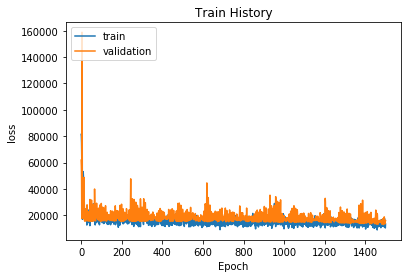

In [29]:
#劃出準確度歷程
import matplotlib.pyplot as plt
def show_tarin_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc="upper left")
    plt.show()
show_tarin_history(train_history,'loss','val_loss')
# show_tarin_history(train_history,'loss','loss')

In [30]:
error=model.predict(XX_train).reshape([len(XX_train)])-np.array(YY_train)
np.average(error**2)**(1/2)

109.6161455928558

In [31]:
error=model.predict(XX_test).reshape([len(XX_test)])-np.array(YY_test)
np.average(error**2)**(1/2)

125.5313470775167

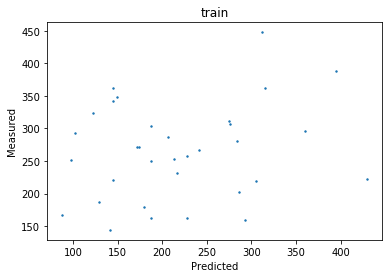

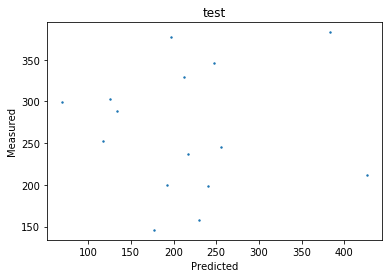

In [32]:
predict=model.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=model.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [33]:
# predict=model.predict(newDataxxG)
# plotPaint(predict,YG,R=1)
# predict=model.predict(newDataxxB)
# plotPaint(predict,YB,R=1)

In [34]:
# predicted_sales = model.predict(newDataxxG)
# predicted_sales

In [35]:
# predicted_sales = model.predict(newDataxxB)
# predicted_sales

# ====================預測類型===================

# 試跑SKLEARN

In [36]:
# 直接將資料分7成訓練集、3成測試集

In [37]:
from sklearn.cross_validation import train_test_split
#將資料分成訓練、測試集 其中測試集佔三成
xx_train, xx_test, Y_train, Y_test =train_test_split(xx,typeY,test_size=0.3,random_state=1)

In [38]:
print(xx_train.shape,xx_test.shape,Y_train.shape,Y_test.shape)

(33, 12) (15, 12) (33,) (15,)


In [39]:
#正確率function
def GorB(someModel,xx_train=xx_train,Y_train=Y_train,xx_test=xx_test,Y_test=Y_test):
    predicted = someModel((xx_train)) #預測結果
    accuracy=list(predicted==Y_train)#回傳true or false的list
    print("訓練集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率


    predicted = someModel((xx_test)) #預測結果
    accuracy=list(predicted==Y_test)#回傳true or false的list
    print("測試集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率

# 線性分類器

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(xx_train, Y_train)

# predicted = clf1.predict((xx_train)) #預測結果
# accuracy=list(predicted==Y_train)#回傳true or false的list
# print("訓練集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率


# predicted = clf1.predict((xx_test)) #預測結果
# accuracy=list(predicted==Y_test)#回傳true or false的list
# print("測試集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率

GorB(clf1.predict)

訓練集正確率：0.7575757575757576
測試集正確率：0.4


# 高斯單純貝氏分類

In [41]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB().fit(xx_train, Y_train)
GorB(clf.predict)

訓練集正確率：0.696969696969697
測試集正確率：0.26666666666666666


# KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier().fit(xx_train, Y_train)
GorB(clf.predict)

訓練集正確率：0.48484848484848486
測試集正確率：0.5333333333333333


# RandomForest

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier().fit(xx_train, Y_train)
GorB(clf.predict)

訓練集正確率：1.0
測試集正確率：0.4


# SVM分類

In [44]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics

# 產生SVC分類器 
#C(誤差容忍，越高，说明越不能容忍出现误差) 
#gamma(隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。支持向量的个数影响训练与预测的速度)
#如果gamma设的太大，高斯分布长得又高又瘦， 会造成只会作用于支持向量样本附近

n=13
for i in range(n):
    for j in range(n):
        i2=10**(i-5)
        j2=10**(j-5)


        classifier = svm.SVC(gamma=i2, C=j2,kernel="rbf")
        # classifier = svm.SVC(gamma=20, C=1,kernel="rbf")
        # classifier = svm.SVC(gamma=1000, C=1000,kernel="linear")
        #訓練
        classifier.fit(xx_train, Y_train)
        GorB(classifier.predict)
        print(i2,j2)

# predicted = classifier.predict((xx_train)) #預測結果
# accuracy=list(predicted==Y_train)#回傳true or false的list
# print("訓練集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率


# predicted = classifier.predict((xx_test)) #預測結果
# accuracy=list(predicted==Y_test)#回傳true or false的list
# print("測試集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率

訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 1e-05
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 0.0001
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 0.001
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 0.01
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 0.1
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 1
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 10
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 100
訓練集正確率：0.3939393939393939
測試集正確率：0.4
1e-05 1000
訓練集正確率：0.7272727272727273
測試集正確率：0.3333333333333333
1e-05 10000
訓練集正確率：0.8787878787878788
測試集正確率：0.3333333333333333
1e-05 100000
訓練集正確率：0.9696969696969697
測試集正確率：0.26666666666666666
1e-05 1000000
訓練集正確率：0.9696969696969697
測試集正確率：0.26666666666666666
1e-05 10000000
訓練集正確率：0.3939393939393939
測試集正確率：0.4
0.0001 1e-05
訓練集正確率：0.3939393939393939
測試集正確率：0.4
0.0001 0.0001
訓練集正確率：0.3939393939393939
測試集正確率：0.4
0.0001 0.001
訓練集正確率：0.3939393939393939
測試集正確率：0.4
0.0001 0.01
訓練集正確率：0.3939393939393939
測試集正確率：0.4
0.0001 0.1
訓練集正確率：0.3939393939393939
測試集正確率：0.4
0.0001 1
訓練集正確率：0.3939

# DNN分類

In [45]:
from sklearn.neural_network.multilayer_perceptron import MLPClassifier

In [46]:
#多層類神經網路分類器 ()
    #random_state=1初始亂數值設定永遠相同 
    #hidden_layer_sizes=(200,100)有兩層隱藏層，分別有200跟100個神經元 預設單層100
    #activation='identity', 'logistic', 'tanh', 'relu' 啟動函數有四種 預設為'relu'
        #'relu'預設，f(x)=max(0,x) 79.8%
        #'logistic'f(x)=1/(1+exp(x)) 對事件的機率有興趣時使用 46%
        #'identity'f(x)=x 48% 
        #'tanh'??? 46%
    #max_iter=500跌代次數，重複訓練的次數 預設為200
# mlp=MLPClassifier(random_state=1,hidden_layer_sizes=(200,500,300),activation="relu",max_iter=500)
mlp=MLPClassifier(random_state=1,hidden_layer_sizes=(300,500,700,300,500),activation="relu",max_iter=1000)
mlp.fit(xx_train,Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300, 500, 700, 300, 500),
       learning_rate='constant', learning_rate_init=0.001, max_iter=1000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [47]:
print("訓練集",len([i for i in mlp.predict(xx_train)==Y_train if i==True])/len(Y_train))
print("測試集",len([i for i in mlp.predict(xx_test)==Y_test if i==True])/len(Y_test))

訓練集 1.0
測試集 0.3333333333333333


# XGBoost 分類

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

GBC=GradientBoostingClassifier()
GBC.fit(xx_train,Y_train)
GorB(GBC.predict)

訓練集正確率：1.0
測試集正確率：0.26666666666666666


# 試跑Keras DNN分類

In [56]:
classes=3
#one-hot
Y_trainO=np_utils.to_categorical(Y_train,classes)
Y_testO=np_utils.to_categorical(Y_test,classes)


In [57]:
Y_trainO[:5],Y_testO[:5]

(array([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.]]), array([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]]))

In [58]:
model=Sequential()  #定義model
input_size=len(xx_train[0])#feature數量
batch_size=50#每批樣本大小
epochs=2000#處理幾輪

model.add(Dense(100,input_dim=input_size)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))
model.add(Dense(200)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))
model.add(Dense(200)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))
model.add(Dense(100)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))

# for i in range(5):
#     model.add(Dense(100-i*10)) 
#     model.add(Activation('relu')) #啟動函數


# model.add(Dense(20)) 
# model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.3))


model.add(Dense(10,activation="sigmoid")) 
# model.add(Dense(10,activation="sigmoid")) 

model.add(Dense(3))  #加入層(緊密層) 產出個數10.輸入個數100 次元
model.add(Activation("softmax"))

In [59]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#optimizer最佳化工具sgd(隨機梯度下降法) loss成本函數(交叉熵)   metrics性能評估方法()


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
# model.compile(loss="MSE",metrics=['accuracy'],optimizer='sgd')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               1300      
_________________________________________________________________
activation_29 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_30 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
__________

In [60]:
#訓練開始 xx為feature Y為label  batch_size為每次放多少進去 epochs為處理幾輪 validation_split為抽多少樣本來驗證 verbose=1為每次顯示
train_history=model.fit(xx_train,Y_trainO,batch_size=batch_size,epochs=epochs,validation_split=0.1,verbose=1)
# train_history=model.fit(xx,Y,batch_size=batch_size,epochs=epochs,verbose=1)



Train on 29 samples, validate on 4 samples
Epoch 1/2000
29/29 [==============================] - 1s 30ms/step - loss: 1.1945 - acc: 0.3103 - val_loss: 1.1185 - val_acc: 0.2500
Epoch 2/2000
29/29 [==============================] - 0s 241us/step - loss: 1.1930 - acc: 0.3103 - val_loss: 1.1146 - val_acc: 0.2500
Epoch 3/2000
29/29 [==============================] - 0s 172us/step - loss: 1.1758 - acc: 0.3103 - val_loss: 1.1100 - val_acc: 0.2500
Epoch 4/2000
29/29 [==============================] - 0s 207us/step - loss: 1.1879 - acc: 0.3103 - val_loss: 1.1050 - val_acc: 0.2500
Epoch 5/2000
29/29 [==============================] - 0s 172us/step - loss: 1.1716 - acc: 0.3448 - val_loss: 1.0999 - val_acc: 0.2500
Epoch 6/2000
29/29 [==============================] - 0s 207us/step - loss: 1.1605 - acc: 0.3103 - val_loss: 1.0952 - val_acc: 0.2500
Epoch 7/2000
29/29 [==============================] - 0s 276us/step - loss: 1.1696 - acc: 0.2069 - val_loss: 1.0910 - val_acc: 0.2500
Epoch 8/2000
29/29 [

Epoch 62/2000
29/29 [==============================] - 0s 241us/step - loss: 1.0682 - acc: 0.4138 - val_loss: 1.1140 - val_acc: 0.2500
Epoch 63/2000
29/29 [==============================] - 0s 276us/step - loss: 1.0823 - acc: 0.3793 - val_loss: 1.1140 - val_acc: 0.2500
Epoch 64/2000
29/29 [==============================] - 0s 207us/step - loss: 1.0709 - acc: 0.4138 - val_loss: 1.1141 - val_acc: 0.2500
Epoch 65/2000
29/29 [==============================] - 0s 172us/step - loss: 1.0794 - acc: 0.3793 - val_loss: 1.1141 - val_acc: 0.2500
Epoch 66/2000
29/29 [==============================] - 0s 172us/step - loss: 1.0850 - acc: 0.3793 - val_loss: 1.1145 - val_acc: 0.2500
Epoch 67/2000
29/29 [==============================] - 0s 172us/step - loss: 1.0792 - acc: 0.4138 - val_loss: 1.1147 - val_acc: 0.2500
Epoch 68/2000
29/29 [==============================] - 0s 172us/step - loss: 1.0891 - acc: 0.4138 - val_loss: 1.1148 - val_acc: 0.2500
Epoch 69/2000
29/29 [==============================] - 

Epoch 123/2000
29/29 [==============================] - 0s 207us/step - loss: 1.0467 - acc: 0.5172 - val_loss: 1.1272 - val_acc: 0.2500
Epoch 124/2000
29/29 [==============================] - 0s 207us/step - loss: 1.0103 - acc: 0.5862 - val_loss: 1.1273 - val_acc: 0.2500
Epoch 125/2000
29/29 [==============================] - 0s 172us/step - loss: 1.0385 - acc: 0.4483 - val_loss: 1.1275 - val_acc: 0.2500
Epoch 126/2000
29/29 [==============================] - 0s 207us/step - loss: 1.0096 - acc: 0.6207 - val_loss: 1.1278 - val_acc: 0.2500
Epoch 127/2000
29/29 [==============================] - 0s 172us/step - loss: 1.0342 - acc: 0.4483 - val_loss: 1.1278 - val_acc: 0.2500
Epoch 128/2000
29/29 [==============================] - 0s 207us/step - loss: 1.0171 - acc: 0.6897 - val_loss: 1.1284 - val_acc: 0.2500
Epoch 129/2000
29/29 [==============================] - 0s 207us/step - loss: 1.0329 - acc: 0.5517 - val_loss: 1.1285 - val_acc: 0.2500
Epoch 130/2000
29/29 [==========================

Epoch 184/2000
29/29 [==============================] - 0s 207us/step - loss: 0.7548 - acc: 0.7586 - val_loss: 1.1990 - val_acc: 0.2500
Epoch 185/2000
29/29 [==============================] - 0s 241us/step - loss: 0.7643 - acc: 0.8621 - val_loss: 1.2038 - val_acc: 0.5000
Epoch 186/2000
29/29 [==============================] - 0s 207us/step - loss: 0.7679 - acc: 0.7931 - val_loss: 1.2101 - val_acc: 0.5000
Epoch 187/2000
29/29 [==============================] - 0s 207us/step - loss: 0.7918 - acc: 0.7931 - val_loss: 1.2113 - val_acc: 0.2500
Epoch 188/2000
29/29 [==============================] - 0s 207us/step - loss: 0.7628 - acc: 0.8276 - val_loss: 1.2101 - val_acc: 0.2500
Epoch 189/2000
29/29 [==============================] - 0s 207us/step - loss: 0.7904 - acc: 0.7931 - val_loss: 1.2099 - val_acc: 0.2500
Epoch 190/2000
29/29 [==============================] - 0s 207us/step - loss: 0.7133 - acc: 0.7931 - val_loss: 1.2085 - val_acc: 0.2500
Epoch 191/2000
29/29 [==========================

Epoch 245/2000
29/29 [==============================] - 0s 172us/step - loss: 0.4213 - acc: 0.8621 - val_loss: 1.4562 - val_acc: 0.2500
Epoch 246/2000
29/29 [==============================] - 0s 172us/step - loss: 0.4491 - acc: 0.9310 - val_loss: 1.4446 - val_acc: 0.2500
Epoch 247/2000
29/29 [==============================] - 0s 172us/step - loss: 0.4237 - acc: 0.8966 - val_loss: 1.4413 - val_acc: 0.2500
Epoch 248/2000
29/29 [==============================] - 0s 172us/step - loss: 0.3803 - acc: 0.8966 - val_loss: 1.4326 - val_acc: 0.2500
Epoch 249/2000
29/29 [==============================] - 0s 172us/step - loss: 0.3572 - acc: 0.9655 - val_loss: 1.4279 - val_acc: 0.2500
Epoch 250/2000
29/29 [==============================] - 0s 172us/step - loss: 0.3717 - acc: 0.8276 - val_loss: 1.4221 - val_acc: 0.2500
Epoch 251/2000
29/29 [==============================] - 0s 207us/step - loss: 0.3674 - acc: 0.8966 - val_loss: 1.4244 - val_acc: 0.2500
Epoch 252/2000
29/29 [==========================

Epoch 306/2000
29/29 [==============================] - 0s 207us/step - loss: 0.2261 - acc: 0.9655 - val_loss: 1.5188 - val_acc: 0.2500
Epoch 307/2000
29/29 [==============================] - 0s 172us/step - loss: 0.1548 - acc: 1.0000 - val_loss: 1.5062 - val_acc: 0.2500
Epoch 308/2000
29/29 [==============================] - 0s 172us/step - loss: 0.2467 - acc: 0.9310 - val_loss: 1.4563 - val_acc: 0.2500
Epoch 309/2000
29/29 [==============================] - 0s 207us/step - loss: 0.2619 - acc: 0.9310 - val_loss: 1.4360 - val_acc: 0.2500
Epoch 310/2000
29/29 [==============================] - 0s 172us/step - loss: 0.1577 - acc: 1.0000 - val_loss: 1.4202 - val_acc: 0.2500
Epoch 311/2000
29/29 [==============================] - 0s 172us/step - loss: 0.1536 - acc: 1.0000 - val_loss: 1.3958 - val_acc: 0.5000
Epoch 312/2000
29/29 [==============================] - 0s 138us/step - loss: 0.1459 - acc: 1.0000 - val_loss: 1.3810 - val_acc: 0.5000
Epoch 313/2000
29/29 [==========================

Epoch 367/2000
29/29 [==============================] - 0s 172us/step - loss: 0.1185 - acc: 1.0000 - val_loss: 1.7243 - val_acc: 0.2500
Epoch 368/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0929 - acc: 1.0000 - val_loss: 1.7155 - val_acc: 0.2500
Epoch 369/2000
29/29 [==============================] - 0s 172us/step - loss: 0.1158 - acc: 0.9655 - val_loss: 1.7079 - val_acc: 0.2500
Epoch 370/2000
29/29 [==============================] - 0s 207us/step - loss: 0.1519 - acc: 0.9655 - val_loss: 1.6806 - val_acc: 0.2500
Epoch 371/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0949 - acc: 1.0000 - val_loss: 1.6659 - val_acc: 0.2500
Epoch 372/2000
29/29 [==============================] - 0s 310us/step - loss: 0.1108 - acc: 1.0000 - val_loss: 1.6614 - val_acc: 0.5000
Epoch 373/2000
29/29 [==============================] - 0s 207us/step - loss: 0.1438 - acc: 0.9655 - val_loss: 1.6321 - val_acc: 0.5000
Epoch 374/2000
29/29 [==========================

Epoch 428/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0885 - acc: 0.9655 - val_loss: 1.9993 - val_acc: 0.2500
Epoch 429/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0613 - acc: 1.0000 - val_loss: 2.0063 - val_acc: 0.2500
Epoch 430/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0633 - acc: 1.0000 - val_loss: 1.9831 - val_acc: 0.2500
Epoch 431/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0641 - acc: 1.0000 - val_loss: 1.9839 - val_acc: 0.2500
Epoch 432/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0625 - acc: 1.0000 - val_loss: 1.9981 - val_acc: 0.2500
Epoch 433/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0547 - acc: 1.0000 - val_loss: 2.0013 - val_acc: 0.2500
Epoch 434/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0487 - acc: 1.0000 - val_loss: 2.0067 - val_acc: 0.2500
Epoch 435/2000
29/29 [==========================

Epoch 489/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0772 - acc: 0.9655 - val_loss: 1.9404 - val_acc: 0.2500
Epoch 490/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0708 - acc: 1.0000 - val_loss: 1.9561 - val_acc: 0.2500
Epoch 491/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0481 - acc: 1.0000 - val_loss: 1.9834 - val_acc: 0.2500
Epoch 492/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0356 - acc: 1.0000 - val_loss: 2.0009 - val_acc: 0.2500
Epoch 493/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0315 - acc: 1.0000 - val_loss: 2.0178 - val_acc: 0.2500
Epoch 494/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0421 - acc: 1.0000 - val_loss: 2.0378 - val_acc: 0.2500
Epoch 495/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0584 - acc: 1.0000 - val_loss: 2.0596 - val_acc: 0.2500
Epoch 496/2000
29/29 [==========================

Epoch 550/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0266 - acc: 1.0000 - val_loss: 2.2141 - val_acc: 0.2500
Epoch 551/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0505 - acc: 1.0000 - val_loss: 2.1618 - val_acc: 0.2500
Epoch 552/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0250 - acc: 1.0000 - val_loss: 2.1283 - val_acc: 0.2500
Epoch 553/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0268 - acc: 1.0000 - val_loss: 2.0976 - val_acc: 0.2500
Epoch 554/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0318 - acc: 1.0000 - val_loss: 2.0753 - val_acc: 0.2500
Epoch 555/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0239 - acc: 1.0000 - val_loss: 2.0550 - val_acc: 0.2500
Epoch 556/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0593 - acc: 0.9655 - val_loss: 2.0921 - val_acc: 0.2500
Epoch 557/2000
29/29 [==========================

Epoch 611/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 2.4920 - val_acc: 0.2500
Epoch 612/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0399 - acc: 1.0000 - val_loss: 2.4672 - val_acc: 0.2500
Epoch 613/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0369 - acc: 1.0000 - val_loss: 2.4482 - val_acc: 0.2500
Epoch 614/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0809 - acc: 0.9655 - val_loss: 2.5339 - val_acc: 0.2500
Epoch 615/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0417 - acc: 1.0000 - val_loss: 2.5650 - val_acc: 0.2500
Epoch 616/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 2.5928 - val_acc: 0.2500
Epoch 617/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0244 - acc: 1.0000 - val_loss: 2.6183 - val_acc: 0.2500
Epoch 618/2000
29/29 [==========================

Epoch 672/2000
29/29 [==============================] - 0s 138us/step - loss: 0.0269 - acc: 1.0000 - val_loss: 3.2630 - val_acc: 0.2500
Epoch 673/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0298 - acc: 1.0000 - val_loss: 3.2522 - val_acc: 0.2500
Epoch 674/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0244 - acc: 1.0000 - val_loss: 3.2475 - val_acc: 0.2500
Epoch 675/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0883 - acc: 0.9655 - val_loss: 3.2238 - val_acc: 0.2500
Epoch 676/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0228 - acc: 1.0000 - val_loss: 3.2042 - val_acc: 0.2500
Epoch 677/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0250 - acc: 1.0000 - val_loss: 3.1859 - val_acc: 0.2500
Epoch 678/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0330 - acc: 1.0000 - val_loss: 3.1698 - val_acc: 0.2500
Epoch 679/2000
29/29 [==========================

Epoch 733/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0756 - acc: 0.9655 - val_loss: 2.5400 - val_acc: 0.2500
Epoch 734/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0227 - acc: 1.0000 - val_loss: 2.5396 - val_acc: 0.2500
Epoch 735/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0207 - acc: 1.0000 - val_loss: 2.5394 - val_acc: 0.2500
Epoch 736/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0309 - acc: 1.0000 - val_loss: 2.5402 - val_acc: 0.2500
Epoch 737/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 2.5449 - val_acc: 0.2500
Epoch 738/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 2.5456 - val_acc: 0.2500
Epoch 739/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0263 - acc: 1.0000 - val_loss: 2.5597 - val_acc: 0.2500
Epoch 740/2000
29/29 [==========================

Epoch 794/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0214 - acc: 1.0000 - val_loss: 3.4813 - val_acc: 0.2500
Epoch 795/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 3.4877 - val_acc: 0.2500
Epoch 796/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 3.4935 - val_acc: 0.2500
Epoch 797/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 3.4990 - val_acc: 0.2500
Epoch 798/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0516 - acc: 0.9655 - val_loss: 3.4797 - val_acc: 0.2500
Epoch 799/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0251 - acc: 1.0000 - val_loss: 3.4787 - val_acc: 0.2500
Epoch 800/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 3.4770 - val_acc: 0.2500
Epoch 801/2000
29/29 [==========================

Epoch 855/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 3.3220 - val_acc: 0.2500
Epoch 856/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0118 - acc: 1.0000 - val_loss: 3.3162 - val_acc: 0.2500
Epoch 857/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0111 - acc: 1.0000 - val_loss: 3.3108 - val_acc: 0.2500
Epoch 858/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0209 - acc: 1.0000 - val_loss: 3.2927 - val_acc: 0.2500
Epoch 859/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 3.2907 - val_acc: 0.2500
Epoch 860/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0123 - acc: 1.0000 - val_loss: 3.2848 - val_acc: 0.2500
Epoch 861/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 3.2903 - val_acc: 0.2500
Epoch 862/2000
29/29 [==========================

Epoch 916/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 3.5964 - val_acc: 0.2500
Epoch 917/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 3.5784 - val_acc: 0.2500
Epoch 918/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 3.5640 - val_acc: 0.2500
Epoch 919/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 3.5508 - val_acc: 0.2500
Epoch 920/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 3.5396 - val_acc: 0.2500
Epoch 921/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 3.5322 - val_acc: 0.2500
Epoch 922/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0617 - acc: 0.9655 - val_loss: 3.5360 - val_acc: 0.2500
Epoch 923/2000
29/29 [==========================

Epoch 977/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 3.2766 - val_acc: 0.2500
Epoch 978/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 3.2802 - val_acc: 0.2500
Epoch 979/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 3.2828 - val_acc: 0.2500
Epoch 980/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 3.2850 - val_acc: 0.2500
Epoch 981/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 3.3038 - val_acc: 0.2500
Epoch 982/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0151 - acc: 1.0000 - val_loss: 3.3086 - val_acc: 0.2500
Epoch 983/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0293 - acc: 1.0000 - val_loss: 3.4285 - val_acc: 0.2500
Epoch 984/2000
29/29 [==========================

Epoch 1037/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0117 - acc: 1.0000 - val_loss: 3.5781 - val_acc: 0.2500
Epoch 1038/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 3.5750 - val_acc: 0.2500
Epoch 1039/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0087 - acc: 1.0000 - val_loss: 3.5718 - val_acc: 0.2500
Epoch 1040/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 3.5692 - val_acc: 0.2500
Epoch 1041/2000
29/29 [==============================] - 0s 276us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 3.5679 - val_acc: 0.2500
Epoch 1042/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0093 - acc: 1.0000 - val_loss: 3.5664 - val_acc: 0.2500
Epoch 1043/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 3.5649 - val_acc: 0.2500
Epoch 1044/2000
29/29 [==================

Epoch 1097/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 3.8865 - val_acc: 0.2500
Epoch 1098/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0198 - acc: 1.0000 - val_loss: 3.8870 - val_acc: 0.2500
Epoch 1099/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 3.8937 - val_acc: 0.2500
Epoch 1100/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 3.8976 - val_acc: 0.2500
Epoch 1101/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 3.8995 - val_acc: 0.2500
Epoch 1102/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 3.8986 - val_acc: 0.2500
Epoch 1103/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 3.9080 - val_acc: 0.2500
Epoch 1104/2000
29/29 [==================

Epoch 1157/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 3.9286 - val_acc: 0.2500
Epoch 1158/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 3.9260 - val_acc: 0.2500
Epoch 1159/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0087 - acc: 1.0000 - val_loss: 3.9235 - val_acc: 0.2500
Epoch 1160/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.2500
Epoch 1161/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 3.9194 - val_acc: 0.2500
Epoch 1162/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 3.9175 - val_acc: 0.2500
Epoch 1163/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 3.9160 - val_acc: 0.2500
Epoch 1164/2000
29/29 [==================

Epoch 1217/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 3.7643 - val_acc: 0.2500
Epoch 1218/2000
29/29 [==============================] - 0s 172us/step - loss: 0.1197 - acc: 0.9655 - val_loss: 3.8187 - val_acc: 0.2500
Epoch 1219/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 3.8323 - val_acc: 0.2500
Epoch 1220/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0121 - acc: 1.0000 - val_loss: 3.8384 - val_acc: 0.2500
Epoch 1221/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 3.8438 - val_acc: 0.2500
Epoch 1222/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 3.8486 - val_acc: 0.2500
Epoch 1223/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 3.8543 - val_acc: 0.2500
Epoch 1224/2000
29/29 [==================

Epoch 1277/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 4.0751 - val_acc: 0.2500
Epoch 1278/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 4.1050 - val_acc: 0.2500
Epoch 1279/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 4.1316 - val_acc: 0.2500
Epoch 1280/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 4.1546 - val_acc: 0.2500
Epoch 1281/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 4.1781 - val_acc: 0.2500
Epoch 1282/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 4.1970 - val_acc: 0.2500
Epoch 1283/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 4.2147 - val_acc: 0.2500
Epoch 1284/2000
29/29 [==================

Epoch 1337/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 3.3134 - val_acc: 0.2500
Epoch 1338/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 3.3529 - val_acc: 0.2500
Epoch 1339/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 3.3886 - val_acc: 0.2500
Epoch 1340/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 3.4231 - val_acc: 0.2500
Epoch 1341/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 3.4553 - val_acc: 0.2500
Epoch 1342/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0088 - acc: 1.0000 - val_loss: 3.4868 - val_acc: 0.2500
Epoch 1343/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 3.5149 - val_acc: 0.2500
Epoch 1344/2000
29/29 [==================

Epoch 1397/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 3.5334 - val_acc: 0.2500
Epoch 1398/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0158 - acc: 1.0000 - val_loss: 3.5337 - val_acc: 0.2500
Epoch 1399/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 3.5350 - val_acc: 0.2500
Epoch 1400/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 3.5363 - val_acc: 0.2500
Epoch 1401/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 3.5380 - val_acc: 0.2500
Epoch 1402/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0226 - acc: 1.0000 - val_loss: 3.5482 - val_acc: 0.2500
Epoch 1403/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 3.5546 - val_acc: 0.2500
Epoch 1404/2000
29/29 [==================

Epoch 1457/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 3.2908 - val_acc: 0.2500
Epoch 1458/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 3.2963 - val_acc: 0.2500
Epoch 1459/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 3.3038 - val_acc: 0.2500
Epoch 1460/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 3.3157 - val_acc: 0.2500
Epoch 1461/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 3.3265 - val_acc: 0.2500
Epoch 1462/2000
29/29 [==============================] - 0s 414us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 3.3379 - val_acc: 0.2500
Epoch 1463/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 3.3486 - val_acc: 0.2500
Epoch 1464/2000
29/29 [==================

Epoch 1517/2000
29/29 [==============================] - 0s 276us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 3.3482 - val_acc: 0.2500
Epoch 1518/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 3.3362 - val_acc: 0.2500
Epoch 1519/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 3.3309 - val_acc: 0.2500
Epoch 1520/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 3.3260 - val_acc: 0.2500
Epoch 1521/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 3.3220 - val_acc: 0.2500
Epoch 1522/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 3.3245 - val_acc: 0.2500
Epoch 1523/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 3.3244 - val_acc: 0.2500
Epoch 1524/2000
29/29 [==================

Epoch 1577/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 3.1797 - val_acc: 0.2500
Epoch 1578/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 3.1783 - val_acc: 0.2500
Epoch 1579/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 3.1727 - val_acc: 0.2500
Epoch 1580/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 3.1696 - val_acc: 0.2500
Epoch 1581/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 3.1669 - val_acc: 0.2500
Epoch 1582/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 3.1647 - val_acc: 0.2500
Epoch 1583/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 3.1626 - val_acc: 0.2500
Epoch 1584/2000
29/29 [==================

Epoch 1637/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 3.2689 - val_acc: 0.2500
Epoch 1638/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 3.2696 - val_acc: 0.2500
Epoch 1639/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 3.2697 - val_acc: 0.2500
Epoch 1640/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 3.2595 - val_acc: 0.2500
Epoch 1641/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 3.2558 - val_acc: 0.2500
Epoch 1642/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 3.2525 - val_acc: 0.2500
Epoch 1643/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 3.2493 - val_acc: 0.2500
Epoch 1644/2000
29/29 [==================

Epoch 1697/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 3.3080 - val_acc: 0.2500
Epoch 1698/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 3.3110 - val_acc: 0.2500
Epoch 1699/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 3.3144 - val_acc: 0.2500
Epoch 1700/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 3.3174 - val_acc: 0.2500
Epoch 1701/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 3.3204 - val_acc: 0.2500
Epoch 1702/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 3.3227 - val_acc: 0.2500
Epoch 1703/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 3.3251 - val_acc: 0.2500
Epoch 1704/2000
29/29 [==================

Epoch 1757/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 3.1386 - val_acc: 0.5000
Epoch 1758/2000
29/29 [==============================] - 0s 207us/step - loss: 0.1243 - acc: 0.9655 - val_loss: 3.0489 - val_acc: 0.5000
Epoch 1759/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 3.0130 - val_acc: 0.5000
Epoch 1760/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 2.9845 - val_acc: 0.5000
Epoch 1761/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 2.9620 - val_acc: 0.5000
Epoch 1762/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 2.9452 - val_acc: 0.5000
Epoch 1763/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 2.9338 - val_acc: 0.5000
Epoch 1764/2000
29/29 [==================

Epoch 1817/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 3.0968 - val_acc: 0.2500
Epoch 1818/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 3.1017 - val_acc: 0.2500
Epoch 1819/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0563 - acc: 0.9655 - val_loss: 3.1110 - val_acc: 0.2500
Epoch 1820/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 3.1158 - val_acc: 0.2500
Epoch 1821/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 3.1190 - val_acc: 0.2500
Epoch 1822/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 3.1226 - val_acc: 0.2500
Epoch 1823/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 3.1168 - val_acc: 0.2500
Epoch 1824/2000
29/29 [==================

Epoch 1877/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 3.1488 - val_acc: 0.2500
Epoch 1878/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 3.1492 - val_acc: 0.2500
Epoch 1879/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 3.1567 - val_acc: 0.2500
Epoch 1880/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 3.1600 - val_acc: 0.2500
Epoch 1881/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 3.1634 - val_acc: 0.2500
Epoch 1882/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 3.1664 - val_acc: 0.2500
Epoch 1883/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 3.1692 - val_acc: 0.2500
Epoch 1884/2000
29/29 [==================

Epoch 1937/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 3.2257 - val_acc: 0.2500
Epoch 1938/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 3.2334 - val_acc: 0.2500
Epoch 1939/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 3.2404 - val_acc: 0.2500
Epoch 1940/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 3.2469 - val_acc: 0.2500
Epoch 1941/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 3.2530 - val_acc: 0.2500
Epoch 1942/2000
29/29 [==============================] - 0s 172us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 3.2584 - val_acc: 0.2500
Epoch 1943/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 3.2635 - val_acc: 0.2500
Epoch 1944/2000
29/29 [==================

Epoch 1997/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 3.3532 - val_acc: 0.2500
Epoch 1998/2000
29/29 [==============================] - 0s 241us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 3.3556 - val_acc: 0.2500
Epoch 1999/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 3.3578 - val_acc: 0.2500
Epoch 2000/2000
29/29 [==============================] - 0s 207us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 3.3598 - val_acc: 0.2500


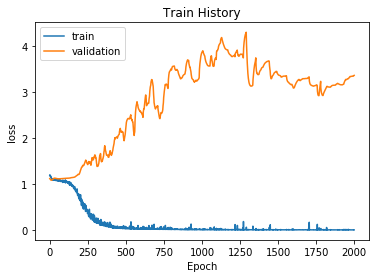

In [62]:
#劃出準確度歷程
import matplotlib.pyplot as plt
def show_tarin_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc="upper left")
    plt.show()
show_tarin_history(train_history,'loss','val_loss')
# show_tarin_history(train_history,'loss','loss')

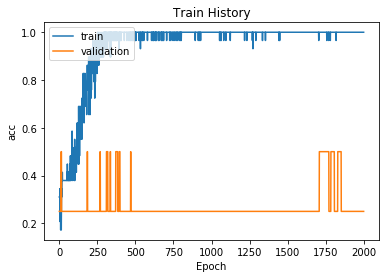

In [63]:
show_tarin_history(train_history,'acc','val_acc')

In [64]:
score=model.evaluate(xx_train,Y_trainO,verbose=1)
print('Train accuracy:',score[1])
score=model.evaluate(xx_test,Y_testO,verbose=1)
print('Test accuracy:',score[1])

33/33 [==============================] - 0s 818us/step
Train accuracy: 0.9090909090909091
15/15 [==============================] - 0s 133us/step
Test accuracy: 0.2666666805744171


In [65]:
list(model.predict_classes(xx_test)==Y_test).count(True)/len(Y_test)

0.26666666666666666

In [66]:
model.predict_classes(xx_test)

array([1, 0, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2, 1], dtype=int64)

# 分群

# kmeans分群 (xx>>正規化後的feature)

如果直接用X(非正規化feature)則會變成按人口區分(因為人口的值特別高)

In [375]:
xx.shape

(48, 12)

In [376]:
Y.shape

(48,)

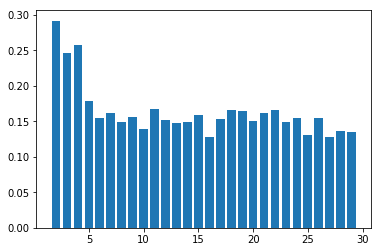

[0.29147422959188507, 0.24545218690147289, 0.25721177106522647, 0.1778604359000476, 0.15443003660001, 0.16214428239409576, 0.14895609277069413, 0.1554964995232929, 0.13953923475377814, 0.16742741241418924, 0.15209262414968372, 0.14764564817736953, 0.1493931145658289, 0.15930947731122688, 0.12745146723145995, 0.15303365811855202, 0.16512181654277389, 0.1649010378647958, 0.1509703940483368, 0.16205564136021788, 0.16645410445548134, 0.14915408347035372, 0.15429027045708874, 0.13021241326292096, 0.1544561055845437, 0.1284170177517373, 0.1366650364673213, 0.13554122357352608]


In [377]:
from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# 印出效用最高的kmeans群
silhouette_avgs = []
ks = range(2, 30)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k,max_iter=3000).fit(xx)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(xx, cluster_labels) #組間變異
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 30 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

In [411]:
k=4
km = KMeans(n_clusters=k,max_iter=3000)  #K=4群
y_pred = km.fit_predict(xx)

In [412]:
y_pred

array([1, 0, 0, 1, 2, 1, 2, 2, 2, 1, 3, 0, 1, 2, 3, 1, 1, 0, 2, 0, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 2, 1, 2, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 3])

In [413]:
#利用PCA降維法、將feature印射在二維空間
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_xx = pca.fit_transform(xx)

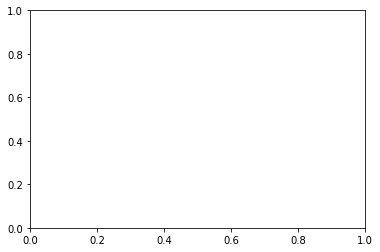

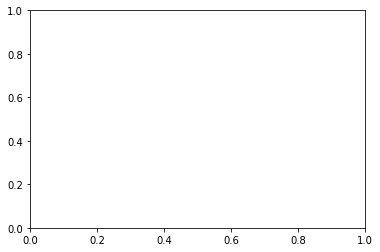

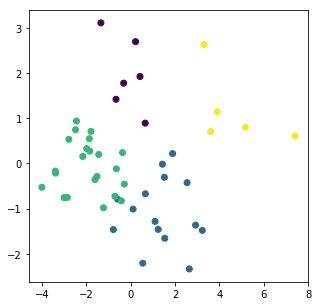

['costPower', 'human', 'simCostDien', 'busStation', 'conStore', 'star', 'mc', 'ken', 'wa', 'watson', 'pxmart', 'carrefour']
第0群資料中心
[1.43, -0.27, -0.2, 1.03, -0.28, -0.27, 0.09, -0.3, -0.1, -0.23, -0.42, 1.32]
第1群資料中心
[-0.46, 0.59, 1.02, 0.3, 0.53, 0.18, 0.26, 0.58, 0.97, 0.3, 0.44, -0.1]
第2群資料中心
[-0.42, -0.59, -0.6, -0.53, -0.68, -0.58, -0.69, -0.46, -0.72, -0.65, -0.58, -0.3]
第3群資料中心
[1.51, 1.14, -0.18, 0.2, 1.73, 2.35, 2.14, 0.64, 0.35, 2.25, 1.73, 0.04]


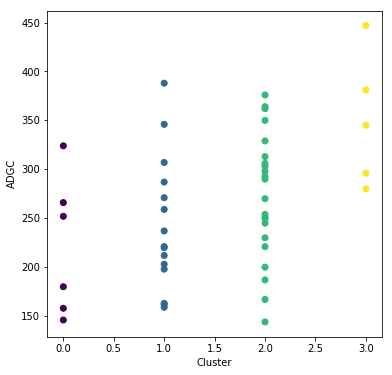

In [422]:
plt.figure(figsize=(5, 5))
# plt.xlabel('costPower')
# plt.ylabel('Nhuman')
# plt.scatter(xx[:, 0], xx[:, 1], c=y_pred) #C是第三維度 已顏色做維度
plt.scatter(reduced_xx.T[0], reduced_xx.T[1], c=y_pred)
plt.legend()
plt.show()


print([i.replace("_Analyze","").replace("N","") for i in ['costPower_Analyze','Nhuman_Analyze',"NsimCostDien",
        'NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze',
        'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze',
        'Nwatson_Analyze','Npxmart_Analyze','Ncarrefour_Analyze']])
x=0
for i in np.around(km.cluster_centers_,2):
    print("第{}群資料中心".format(x),list(i),sep="\n")
    x+=1
plt.figure(figsize=(6, 6))
plt.xlabel('Cluster')
plt.ylabel('ADGC')
plt.scatter(y_pred, Y, c=y_pred) #C是第三維度 已顏色做維度
plt.show()

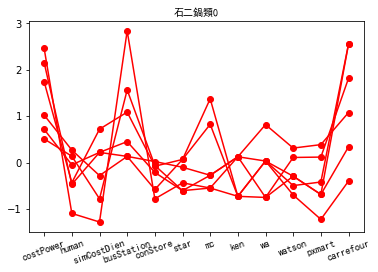

[180, 146, 266, 252, 158, 324]


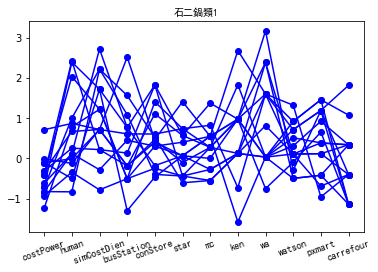

[163, 198, 162, 221, 203, 159, 307, 212, 287, 388, 237, 259, 271, 220, 346]


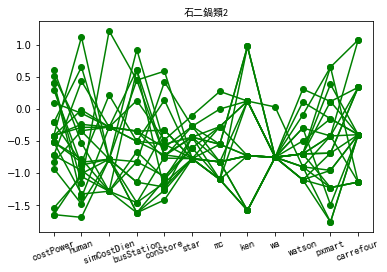

[221, 187, 251, 270, 230, 250, 245, 144, 313, 167, 200, 303, 362, 298, 376, 329, 350, 290, 306, 364, 254, 293]


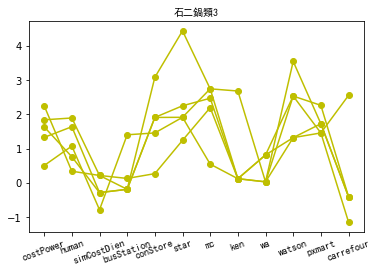

[280, 296, 447, 345, 381]


In [425]:
xlabels=[i.replace("_Analyze","").replace("N","") for i in ['costPower_Analyze','Nhuman_Analyze',"NsimCostDien",
        'NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze',
        'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze',
        'Nwatson_Analyze','Npxmart_Analyze','Ncarrefour_Analyze']]
style = ['o-r', 'o-b', 'o-g','o-y']
for i in range(k):
    plt.figure()
    aa=[]
    for j,x,a in zip(y_pred,xx,Y):
        if j==i:
            plt.plot(range(1, len(xx[0])+1), x, style[i],)
            plt.xticks(range(1, len(xx[0])+1), xlabels, rotation = 20,fontproperties='SimHei') #坐标标签
            plt.title(u'石二鍋類%s' %(i),fontproperties='SimHei') #我们计数习惯从1开始
            plt.subplots_adjust(bottom=0.15) #调整底部
            aa.append(a)
    plt.show()
    print(aa)

# Agglomerative分群

In [1]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage,dendrogram
#這裡使用scipy的層次聚類函數
Z = linkage(xx, method = 'ward', metric = 'euclidean') #譜系聚類圖
P = dendrogram(Z, 0) #畫譜系聚類圖
plt.show()

NameError: name 'xx' is not defined

In [417]:
from sklearn.cluster import AgglomerativeClustering #導入sklearn的層次聚類函數
model = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
model.fit(xx)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x00000000062C5F28>)

In [418]:
model.labels_

array([1, 3, 3, 1, 0, 1, 0, 0, 0, 1, 2, 3, 0, 0, 2, 1, 1, 3, 0, 3, 2, 0,
       0, 1, 0, 0, 0, 3, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 2], dtype=int64)

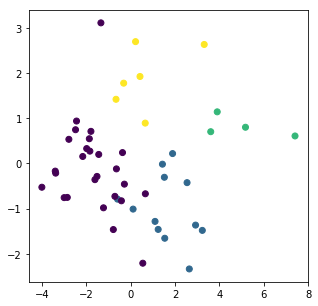

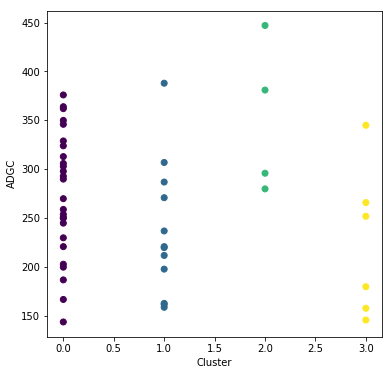

In [419]:
plt.figure(figsize=(5, 5))
# plt.xlabel('costPower')
# plt.ylabel('Nhuman')
# plt.scatter(xx[:, 0], xx[:, 1], c=y_pred) #C是第三維度 已顏色做維度
plt.scatter(reduced_xx.T[0], reduced_xx.T[1], c=model.labels_)
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.xlabel('Cluster')
plt.ylabel('ADGC')
plt.scatter(model.labels_, Y, c=model.labels_) #C是第三維度 已顏色做維度
plt.show()